In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
import design_parameters as dp

In [11]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, poly,
                   R_readout=0.4, sidelength=1.889, debug=False, wall_thickness=dp.wall_thickness, 
                   wall_scint_gap=dp.wall_scint_gap, minCellAreaFraction=1/3,
                  augment_cells=False):
    if wall_thickness!=0:
        poly=poly.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(poly.exterior.xy[1])
    
    nrows = int((max(poly.exterior.xy[1])-min(poly.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+3)
    
    y0=(max(poly.exterior.xy[1])+min(poly.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(poly.exterior.xy[0])-min(poly.exterior.xy[0]))/(sidelength*3/2))+3
    x0=min(poly.exterior.xy[0])
    
    
    
    # x,y are the position of the SiPM and dimple center
    # xh and yh are the position of the center of the hexagon.  
    # These are the same for a regular hexagon or any cropped hexagon that doesn't have a shifted dimple
    d={a:[] for a in "x y xh yh row col boundsx boundsy area dimpleshift cropped augmented scint_boundsx scint_boundsy scint_area deadzone".split()}
    
    
    shiftX=[-sidelength, 0, sidelength][layer%3]
    shiftY=[0, 0, 0][layer%3]
    
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(-1, ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            xh=x
            yh=x
            
            xc=x
            yc=y
            
            cellTooSmall=False
            point=Point(x,y)
            #check if the dimple fits inside the boundaries.
            if not point.buffer(R_readout).within(poly):
                hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
                overlap=poly.intersection(hexagon)
                if overlap.area==0:
                    continue
                
                # now see if shifting the dimple to the centroid will allow the dimple to fit
                # otherwise merge with neighbors
                centroid=overlap.centroid
                if not centroid.buffer(R_readout).within(poly):
                    cellTooSmall=True
                    
                # now see if the cell's area is more than a specified fraction of a 
                # standard hexagon's area.  otherwise merge with neighbors
                if overlap.area/hexagon.area <  minCellAreaFraction:
                    cellTooSmall=True
                    
                # if the cell fragment fails these criteria,
                # either merge it with one of its neighbors,
                # or flag the fragment as a deadzone
                if cellTooSmall and augment_cells:
                    continue
                elif cellTooSmall:
                    d['deadzone'].append(1)
                else:
                    d['deadzone'].append(0)
                xc,yc = centroid.xy[0],centroid.xy[1]
                
                if type(xc) != float:
                    xc=float(xc[0])
                if type(yc) != float:
                    yc=float(yc[0])
                
                d['dimpleshift'].append(1)
            else :
                d['dimpleshift'].append(0)
                d['deadzone'].append(0)
            #print(type(xc))
            d['x'].append(xc)
            d['y'].append(yc)
            
            d['xh'].append(x)
            d['yh'].append(y)
            
            d['row'].append(i)
            d['col'].append(j)
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if poly.contains(hexagon):
                cropped = 0
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell.
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
            elif not cellTooSmall :
                cropped = 1
                newpoly=poly.intersection(hexagon)
                #print(newpoly.exterior)
                d['boundsx'].append(newpoly.exterior.xy[0])
                d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                d['scint_boundsx'].append(scint.exterior.xy[0])
                d['scint_boundsy'].append(scint.exterior.xy[1])
                d['scint_area'].append(scint.area)
            
            else: # for entries where a cell is not placed
                cropped=1
                newpoly=poly.intersection(hexagon)
                if not isinstance(newpoly, Polygon): 
                    #only happens if cropping the cell splits it into multiple parts
                    #very rare, but don't want this to crash
                    d['boundsx'].append(newpoly.geoms[0].exterior.xy[0])
                    d['boundsy'].append(newpoly.geoms[0].exterior.xy[1])
                else :
                    d['boundsx'].append(newpoly.exterior.xy[0])
                    d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                d['scint_boundsx'].append([])
                d['scint_boundsy'].append([])
                d['scint_area'].append(0)
                
                
            d['cropped'].append(cropped)
            d['augmented'].append(0) # no augmenting at this stage yet.  
    df=pd.DataFrame(d)
    
    
    # the cell augmentation feature merges small fragments of cells on the edge of the 
    # detector with their whole neighbors.  If we choose not to use this feature, then we can 
    if not augment_cells:
        if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
        return df
    
    #now extend any cells that need extending.  Need to find a better way to do this
    for i in range(len(df)):
        #check if the neighboring cell is a fragment (which is not in the dataframe)
        #.  If so, take a piece of it and add it to the current cell.  
        dc, dr = (1, 1,0, -1, -1,0), (-1, 1,2,1, -1, -2)
        
        for j in range(len(dc)):
            r=df.row[i]+dr[j]
            c=df.col[i]+dc[j]
            if not len(df.query(f'row== {r} and col=={c}')):
                cell=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                #find center of the fragmented 
                x=x0+(df.col[i]+dc[j])*sidelength*3/2+shiftX
                y=y0+sidelength*np.sqrt(3)/2*(df.row[i]+dr[j])+shiftY
                
                corner1 = (x+df.xh[i])/2+(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2-(df.xh[i]-x)/np.sqrt(3)/2
                corner2 = (x+df.xh[i])/2-(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2+(df.xh[i]-x)/np.sqrt(3)/2
                
                
                merge=Polygon([(x,y), corner1, (df.xh[i], df.yh[i]),corner2])
                
                newpoly=unary_union([cell,merge])
                newpoly=poly.intersection(newpoly).simplify(.0001)
                #print(newpoly)
                if not type(newpoly)== Polygon:
                    if debug: print("warning disjointed polygon!", type(newpoly), j)
                    continue
                df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                df.loc[i,"area"]=newpoly.area
                
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                df.loc[i,'scint_area']=scint.area
                
                #if two consecutive neighbors are fragments, merge a larger fraction of both of them into this one
                for dj in 1,:
                    r2=df.row[i]+dr[(j+dj)%6]
                    c2=df.col[i]+dc[(j+dj)%6]
                    if not len(df.query(f'row== {r2} and col=={c2}')):
                        x2=x0+c2*sidelength*3/2+shiftX
                        y2=y0+sidelength*np.sqrt(3)/2*r2+shiftY
                        
                        corner3 = 2*(x+x2)/3-df.xh[i]/3,2*(y+y2)/3-df.yh[i]/3
                        
                        
                        
                        merge=Polygon([(x,y), corner3, (x2,y2), (df.xh[i], df.yh[i])])
                        #print(merge.area)
                        newpoly=unary_union([newpoly,merge])
                        newpoly=poly.intersection(newpoly)
                        #print(newpoly)
                        if not type(newpoly)== Polygon:
                            if debug: print("warning disjointed polygon!","XXXX")
                            continue
                        df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                        df.loc[i,"area"]=newpoly.area
                        
                        scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                        df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                        df.loc[i,'scint_area']=scint.area
                        
                tol=1e-7
                if abs(newpoly.area-cell.area)/cell.area>tol:
                    df.loc[i,"augmented"]=1
                
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
    return df
            

In [12]:

def draw_layer(layer, R_readout=0.4, sidelength=1.889, fillDimple=True, color=None, shade_deadzone=True):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    if color == None:
        color='krb'[layer%3] 
    
    for side in "LR":
        boundaries=dp.layer_boundaries(layer, side)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color)
        df = cell_positions(layer,boundaries, R_readout, sidelength)
        for i in range(len(df)):
            plt.plot(df.boundsx[i], df.boundsy[i], color=color)
            if not df.deadzone[i]:
                plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                          linestyle='' if fillDimple else '-',
                                                        fill=fillDimple))
            elif shade_deadzone:
                plt.gca().add_patch(mpl.patches.Polygon(list(zip(df.boundsx[i], df.boundsy[i])), color=color,
                                                       alpha=0.3))
            
            #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

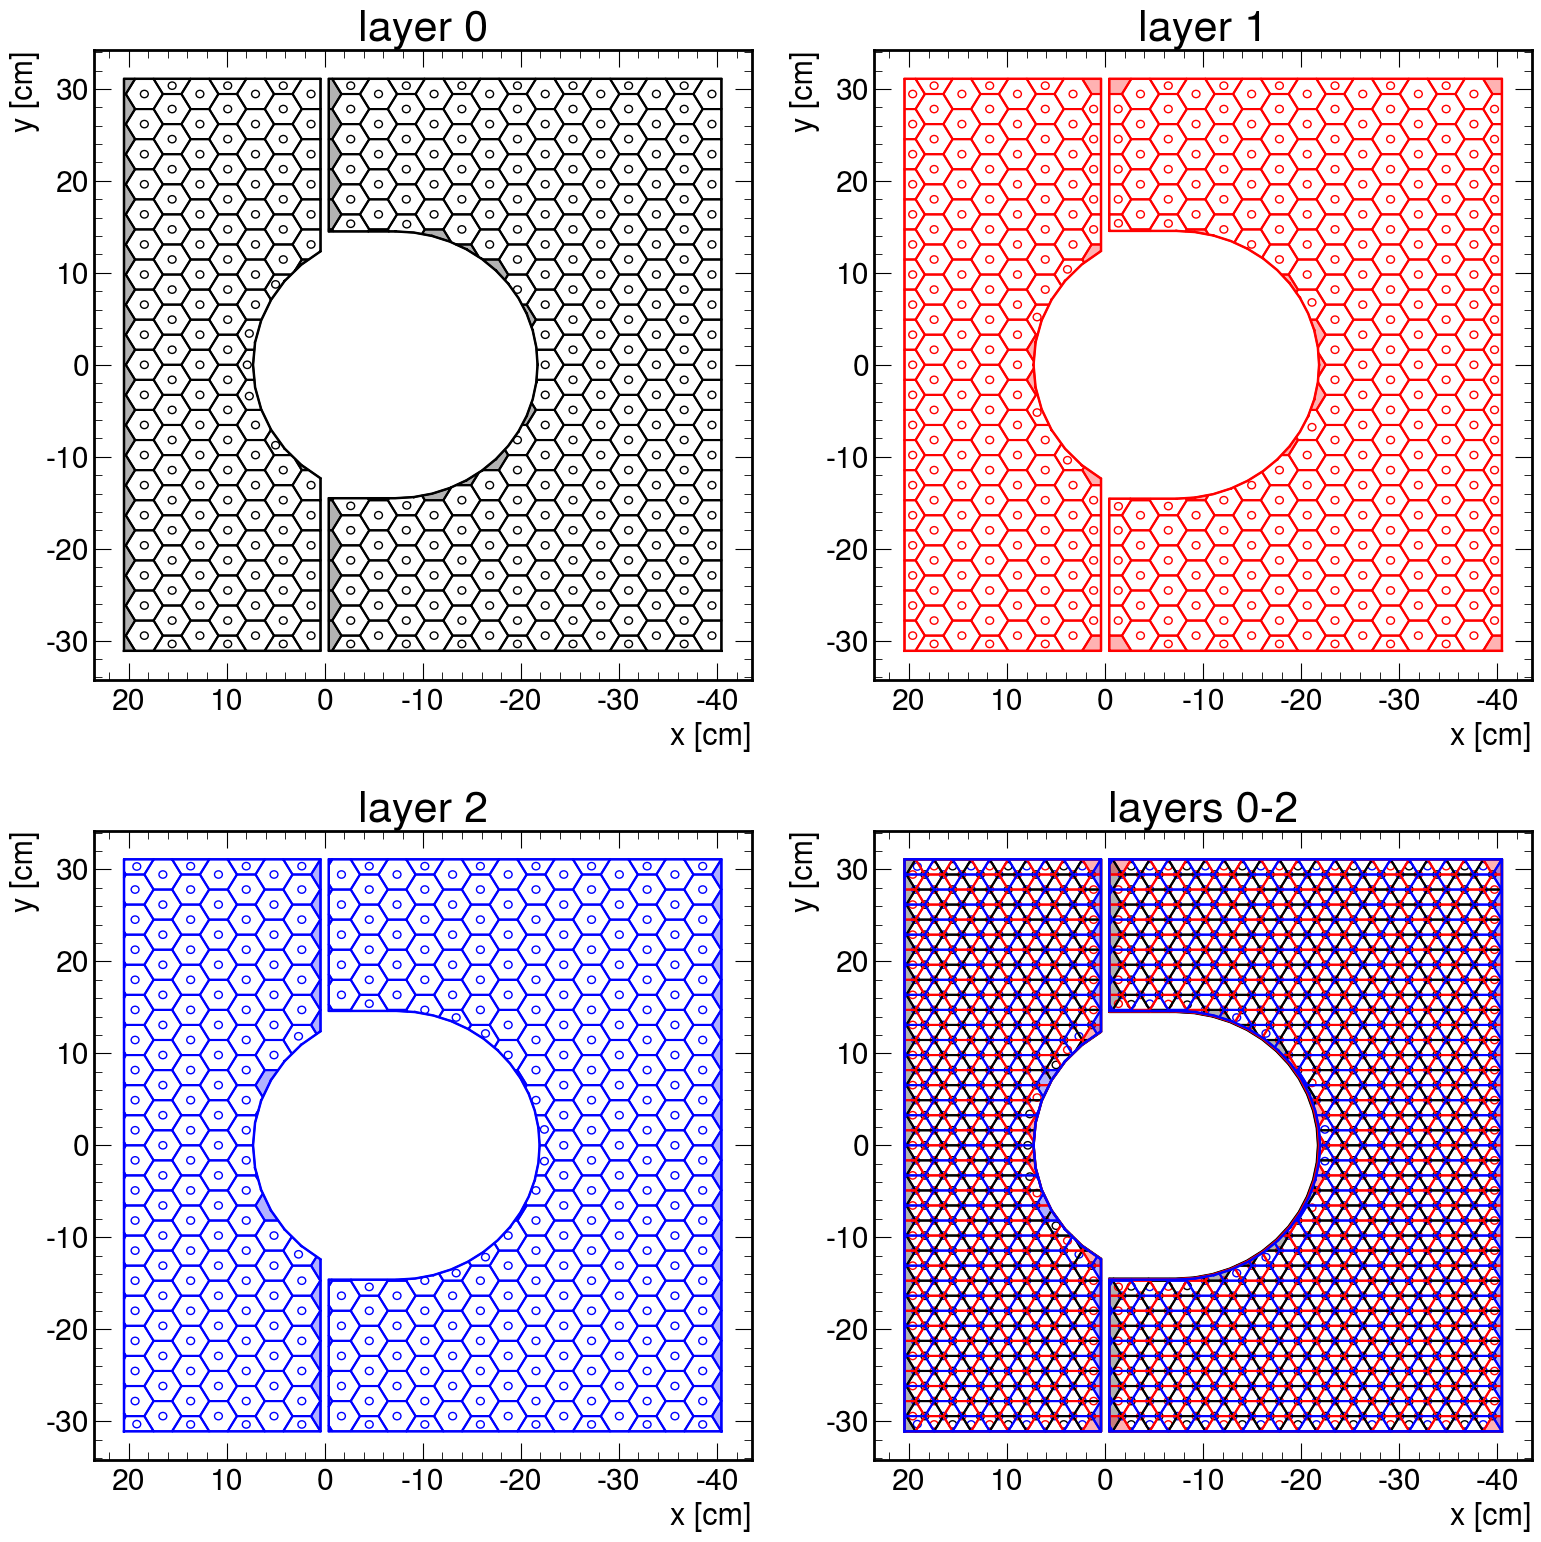

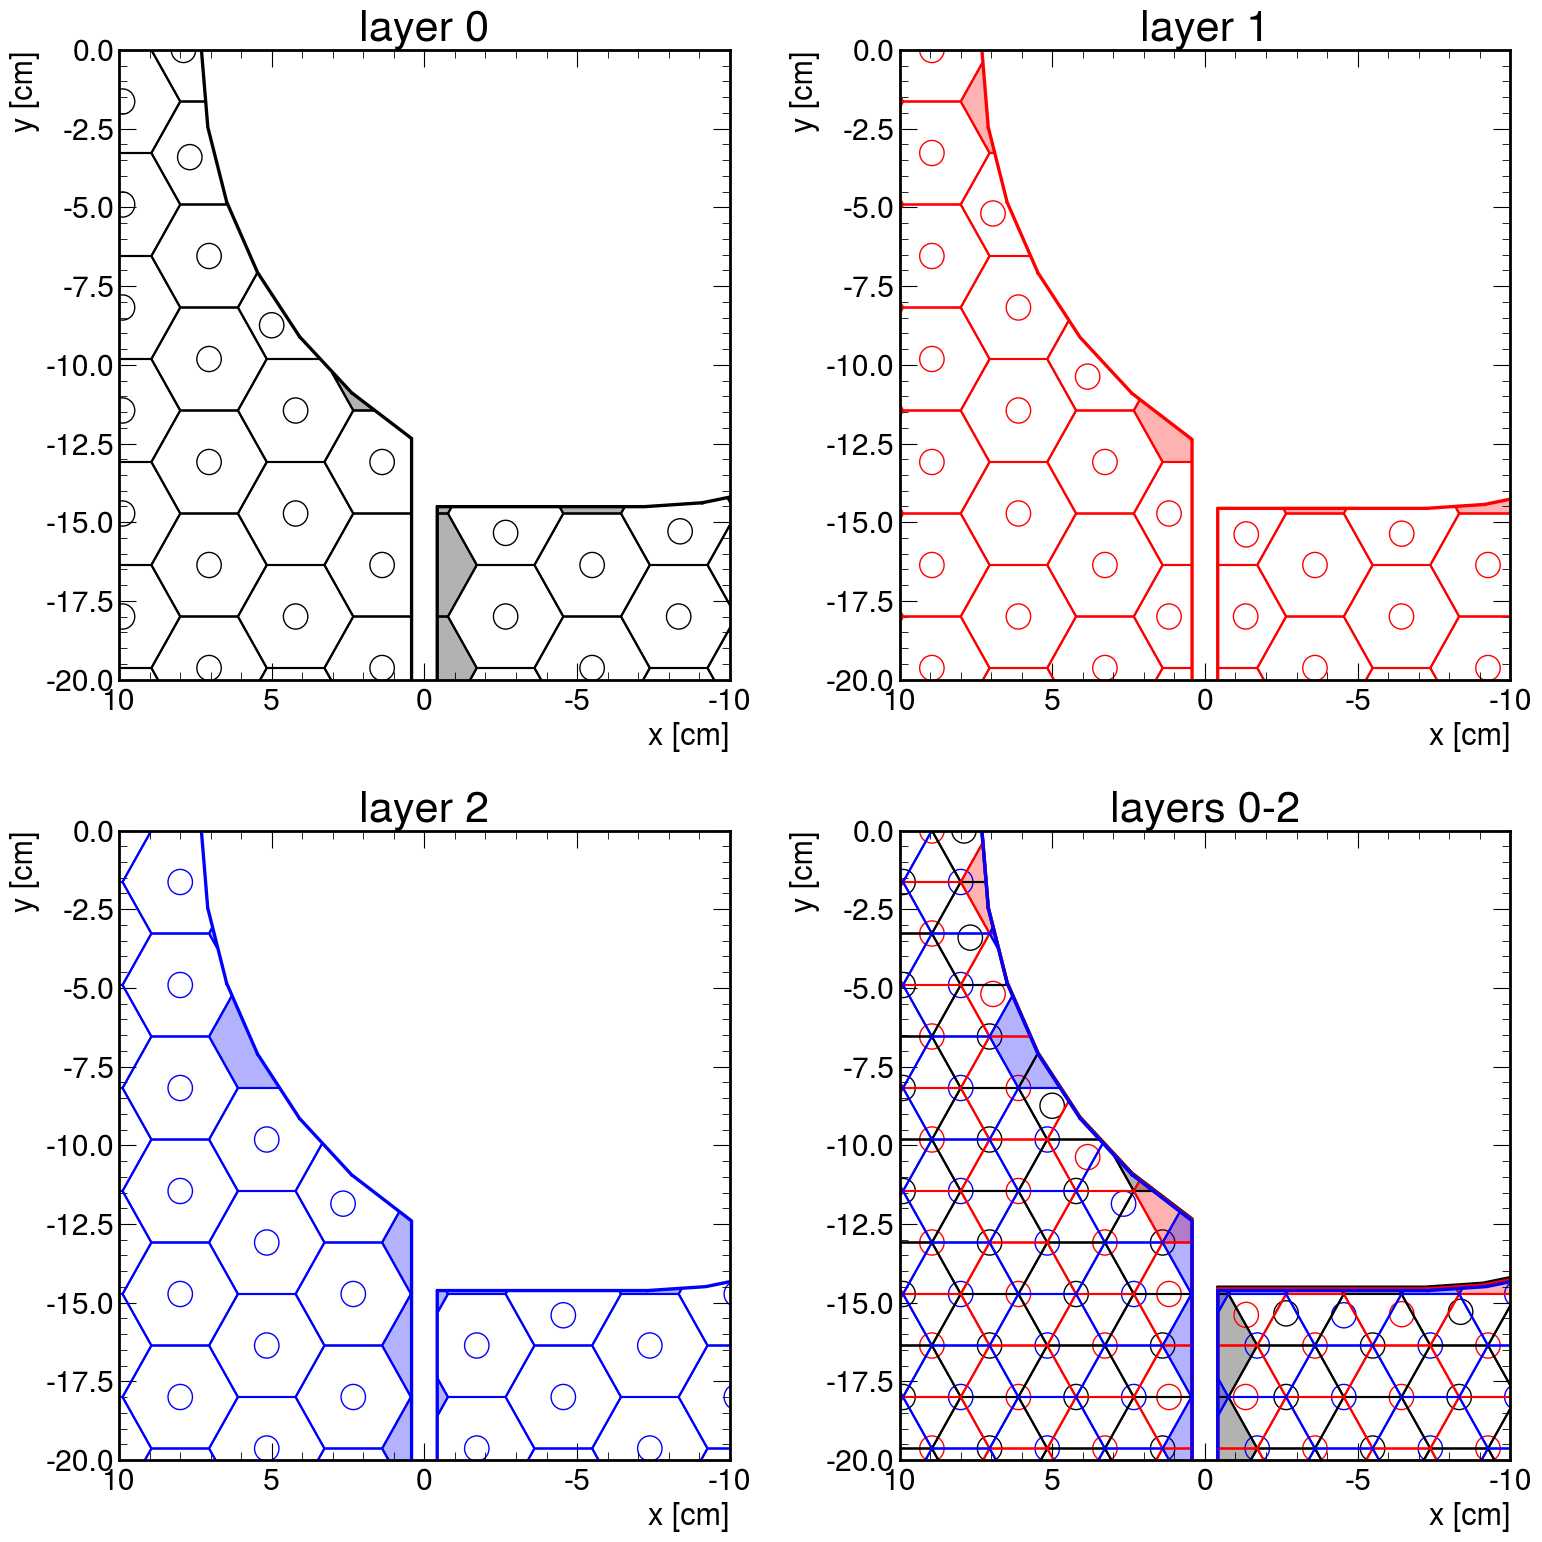

In [13]:

sidelength=dp.sidelengths[0]


for zoom in False, True:
    arg=dict(fillDimple=False, sidelength=sidelength)
    fig,axs=plt.subplots(2,2, figsize=(16,16))
    for i in range(3):

        plt.sca(axs[i//2][i%2])
        plt.title(f"layer {i}")
        draw_layer(i, **arg)
        plt.gca().invert_xaxis()
        plt.sca(axs[1][1])
        plt.title(f"layers 0-2")
        draw_layer(i, **arg)
    axs[1][1].invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)
            if zoom:
                ax.set_xlim(-10, 10)
                ax.set_ylim(-20, 0)
                ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig(f"Layers_0-2{'_zoom' if zoom else ''}.pdf")
    plt.show()

L:
   dz layer 0:,40.31
   dz layer 1:,10.76
   dz layer 2:,25.07
   dz layers 0,1 overlap:,0.21258667350157878
   dz layers 0,2 overlap:,0.9013847880082376
   dz layers 1,2 overlap:,2.743797060266062
   dz layers 0,1,2 overlap:,0.0
R:
   dz layer 0:,39.69
   dz layer 1:,18.91
   dz layer 2:,32.83
   dz layers 0,1 overlap:,3.6556903294821197
   dz layers 0,2 overlap:,2.023491357517188
   dz layers 1,2 overlap:,1.8226703595748037
   dz layers 0,1,2 overlap:,0.1881021165345985


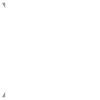

In [14]:
#check how much space is shared cell-too-small deadzone between all three layers
for side in "LR":
    dzs=[]
    for layer in range(3):
        df=cell_positions(layer,dp.layer_boundaries(layer, side))
        for i in range(len(df)):
            dzs.append(None)
            if df.deadzone[i]:
                p=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                if dzs[layer] is None:
                    dzs[layer] = p
                else :
                    dzs[layer] = p | dzs[layer]
    print(f"{side}:")
    for i in range(3):
        print(f"   dz layer {i}:,{dzs[i].area:.2f}")
    for i in range(3):
        for j in range(3):
            if j >i:
                print(f"   dz layers {i},{j} overlap:,{(dzs[i]& dzs[j]).area}")
    print(f"   dz layers 0,1,2 overlap:,{(dzs[0]& dzs[1] & dzs[2]).area}")

    
(dzs[0]& dzs[1] & dzs[2])                                      
        

In [15]:
def print_summary_stats(df, boundary):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=boundary.area
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"area covered by regular hexagons: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"# of regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")
    
    scint_area=sum(df.scint_area)
    scint_hex_area=sum(df.query("augmented==0 and cropped==0").scint_area)
    
    print(f"scintillator area: {scint_area} cm^2")
    print(f"dead area: {tot_area-scint_area:.1f} cm^2  ({100*(tot_area-scint_area)/scint_area:.1f}%)")
    
    
    print(f"area covered by regular hexagon scintillators: {scint_hex_area:.1f} cm^2 ({100*scint_hex_area/tot_area:.1f}% of total)")
    
    

In [16]:
def write_for_openscad(df, file=None, wall_thickness=dp.wall_thickness, frame_height=0.3):
    cm=10
    segments=[]
    print("segments=[", file=file)
    lines=[]
    #keep track of 90 degree corners, so that they can be made 90 degree square corners instead of rounded
    corners=[]
    for i in range(len(df)):
        for j in range(len(df.boundsx[i])-1):
            segment = {(df.boundsx[i][j], df.boundsy[i][j]), (df.boundsx[i][j+1], df.boundsy[i][j+1])}
            tol=1e-6
            if j!=0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][j-1])<tol \
                      or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][j-1])<tol) or \
                j==0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][-2])<tol \
                       or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][-2])<tol):
                corner = (df.boundsx[i][j], df.boundsy[i][j])
                #print(corner)
                if corner not in corners:
                    corners.append(corner)
            if segment not in segments:
                lines.append(f"[[{cm*df.boundsx[i][j]:.3f},{cm*df.boundsy[i][j]:.3f}], [{cm*df.boundsx[i][j+1]:.3f}, {cm*df.boundsy[i][j+1]:.3f}]]")
                segments.append(segment)
        #print()
    print(",\n".join(lines), file=file)
    print("];", file=file)
    
    #add points for square corners if applicable.  
    if corners:
        print("corners=[", file=file)
        lines=[]
        for corner in corners:
            lines.append(f"  [{cm*corner[0]:.3f}, {cm*corner[1]:.3f}]")
        print(",\n".join(lines)+"\n];", file=file)
    else:
        print("corners=[];", file=file)
    print(f"wall_thickness={wall_thickness*cm};\nframe_height={frame_height*cm};", file=file)
    print(f"include <make_3d_frame.scad>", file=file)

In [17]:
#now test this for the first and last layers:
wall_thickness=0.08
frame_height=0.3

for layer, sidelength in zip((0, 53),(dp.sidelengths[0], dp.sidelengths[-1])):
    
    scadfile=f"openscad/layer_{layer}.scad"
    with open(scadfile, "w") as f:
        
        for side in "LR":
            #begin new scope for each side
            print(f"module side{side}() {{", file=f)
            #print("{", file=f)

            bounds=dp.layer_boundaries(layer, side, dp.beampipe0)
            df=cell_positions(layer, bounds,
                               R_readout=0.4, sidelength=sidelength)
            print(f"side: {side} layer: {layer}")
            print_summary_stats(df, bounds)
            write_for_openscad(df, file=f, wall_thickness=wall_thickness, frame_height=frame_height)
            print("}", file=f)
            print(f"side{side}();", file=f)
            print()
            
        #now add information to put on the plaque
        holeR, holeX=dp.beampipe0.holeR(layer), dp.beampipe0.holeX(layer)
        print("include <make_plaque.scad>", file=f)
        print("lines=[", file=f)
        def add_line(line):
            print(f'"{line}",', file=f)
        add_line(f"layer {layer}")
        add_line(f"hole radius={holeR:.2f} cm")
        add_line(f"hole position={holeX:.2f} cm")
        add_line(f"side length={sidelength:.2f} cm")
        add_line(f"wall height={frame_height:.1f} cm")
        add_line(f"wall thickness={wall_thickness:.1f} cm")
        print("];", file=f)
        print("plaque(lines);", file=f)
    import os
    try:
        os.mkdir("stl")
    except:
        pass
    try:
        os.mkdir("png")
    except:
        pass
    #assuming you have openscad installed 
    stlfile=f"stl/layer_{layer}.stl"
    pngfile=f"png/layer_{layer}.png"
    
    camera="-200,900,1500,-100,0,0"
    os.system(f'OpenSCAD --camera {camera} --imgsize=1600,1600 -o {pngfile} -o {stlfile} {scadfile}') 

side: L layer: 0
total area: 1130.9 cm^2
area covered by regular hexagons: 852.9 cm^2
(regular hexagon area)/(total area): 75.4%
total cells: 147
# of regular hexagon cells: 92
(regular hexagon cells)/(total cells): 62.6%
scintillator area: 1017.3640009421524 cm^2
dead area: 113.5 cm^2  (11.2%)
area covered by regular hexagon scintillators: 801.6 cm^2 (70.9% of total)

side: R layer: 0
total area: 1968.7 cm^2
area covered by regular hexagons: 1501.9 cm^2
(regular hexagon area)/(total area): 76.3%
total cells: 242
# of regular hexagon cells: 162
(regular hexagon cells)/(total cells): 66.9%
scintillator area: 1802.2335156674185 cm^2
dead area: 166.5 cm^2  (9.2%)
area covered by regular hexagon scintillators: 1411.5 cm^2 (71.7% of total)



Fontconfig warning: "/Applications/OpenSCAD.app/Contents/Resources/fonts/fonts.conf", line 84: unknown element "blank"
Compiling design (CSG Products normalization)...
Normalized CSG tree has 4 elements
Geometries in cache: 5046
Geometry cache size in bytes: 3047104
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.442
Geometries in cache: 5048
Geometry cache size in bytes: 3819536
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 22755072
Total rendering time: 0:00:15.805
Top level object is a 3D object:
   Simple:        yes
   Vertices:    11322
   Halfedges:   33966
   Edges:       16983
   Halffacets:  11608
   Facets:       5804
   Volumes:         4
Fontconfig warning: "/Applications/OpenSCAD.app/Contents/Resources/fonts/fonts.conf", line 84: unknown element "blank"


side: L layer: 53
total area: 1115.9 cm^2
area covered by regular hexagons: 418.3 cm^2
(regular hexagon area)/(total area): 37.5%
total cells: 35
# of regular hexagon cells: 8
(regular hexagon cells)/(total cells): 22.9%
scintillator area: 1016.0690973774698 cm^2
dead area: 99.8 cm^2  (9.8%)
area covered by regular hexagon scintillators: 407.6 cm^2 (36.5% of total)

side: R layer: 53
total area: 1691.7 cm^2
area covered by regular hexagons: 1045.7 cm^2
(regular hexagon area)/(total area): 61.8%
total cells: 56
# of regular hexagon cells: 20
(regular hexagon cells)/(total cells): 35.7%
scintillator area: 1548.6533052597738 cm^2
dead area: 143.0 cm^2  (9.2%)
area covered by regular hexagon scintillators: 1018.9 cm^2 (60.2% of total)



Compiling design (CSG Products normalization)...
Normalized CSG tree has 4 elements
Geometries in cache: 1399
Geometry cache size in bytes: 1543792
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.312
Geometries in cache: 1401
Geometry cache size in bytes: 2341856
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 17716480
Total rendering time: 0:00:11.577
Top level object is a 3D object:
   Simple:        yes
   Vertices:     7422
   Halfedges:   22266
   Edges:       11133
   Halffacets:   7710
   Facets:       3855
   Volumes:         4


In [18]:
#now tabulate all layers, and also create a dataframe that contains the summary variables
all_layers ={}
beampipe=dp.beampipe0

sidelengths=dp.sidelengths#[1.889]*9+[2.5*np.sqrt(2)]*9+[3*np.sqrt(2)]*36
absorber_material=['W']*34+['Fe']*20
first_in_gang=[1]*18+[1,1,1,0,0,0,0,0,0,0,0,0]*3
#first_in_gang=[1]*24+[1,1,1,0,0,0,0,0,0]*4

#first_in_gang=[1]*24+[1,1,1,0,0,0]*6
columns=[]
columns+="layer side holeX holeR deadzone_frac channels reg_hexes sidelength absorber_material first_in_gang".split()
columns+="tot_area scint_area deadzone_area".split()
d={a:[] for a in columns}
for layer in range(len(sidelengths)):
    holex=beampipe.holeX(layer)
    holer=beampipe.holeR(layer)
    for side in "LR":
        sidelength=sidelengths[layer]
        bounds=dp.layer_boundaries(layer, side)
        df_layer_side=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelength,minCellAreaFraction=1/3, augment_cells=False)
        
        all_layers[(layer, side)]=df_layer_side
        d['layer'].append(layer)
        d['side'].append(side)
        d['holeX'].append(holex)
        d['holeR'].append(holer)
        tot_area=bounds.area
        d['tot_area'].append(tot_area)
        scint_area=sum(df_layer_side.scint_area)
        d['scint_area'].append(scint_area)
        deadzone_area=tot_area-scint_area
        d['deadzone_area'].append(deadzone_area)
        
        deadzone_frac = deadzone_area/tot_area
        d['deadzone_frac'].append(deadzone_frac)
        
        d['channels'].append(len(df_layer_side.query("deadzone==0")))
        d['reg_hexes'].append(len(df_layer_side.query('augmented==0 and cropped==0 and deadzone==0')))
        d['sidelength'].append(sidelength)
        d['absorber_material'].append(absorber_material[layer])
        d['first_in_gang'].append(first_in_gang[layer])
        
summary=pd.DataFrame(d)

In [19]:
len(summary.query("absorber_material=='Fe'"))/2

20.0

In [20]:
nlambda_per_layer = {"W": 0.16899, "Fe":0.10697}
nrad_per_layer = {"W": 1.61/0.3504,  "Fe":1.61/1.757}

print(f"side length (cm)  area (cm^2)   layers  n_lambda n_rad cells\thexes channels")
tot_chan=0
nlambda_tot=0
nrad_tot=0
tot_chan_right=0
tot_cells_right=0
tot_hex=0

nchan=[0,0,0]


nsides=2
for i,s in enumerate(set(summary.sidelength)):
    nlay=len(summary.query(f'sidelength=={s}'))/2
    ncell=sum(summary.query(f'sidelength=={s}').channels)
    nhex=sum(summary.query(f'sidelength=={s}').reg_hexes)
    nlambda =sum([nlambda_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    nrad =sum([nrad_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    #print(f"{s:.1f}")
    
    
    nchan[i]=sum(summary.query(f'sidelength=={s} and first_in_gang').channels)
    tot_chan_right+=sum(summary.query(f'sidelength=={s} and first_in_gang and side=="R"').channels)
    tot_cells_right+=sum(summary.query(f'sidelength=={s} and side=="R"').channels)
    tot_chan+=nchan[i]
    tot_hex+nhex
    print(f"{s:.3f}\t\t{s**2*np.sqrt(3)*3/2:.2f}\t\t{nlay:.0f}\t{nlambda:.2f}\t{nrad:.2f}\t{ncell}\t{nhex}\t{nchan[i]}")
print("total layers:", len(summary)/2)
print("total cells:", sum(summary.channels))
print("total channels:", tot_chan)
print("total channels right side:", tot_chan_right)
print("total cells right side:", tot_cells_right)
print("total regular hexes:", sum(summary.reg_hexes))
print(f"frac regular hexes:{100*sum(summary.reg_hexes)/sum(summary.channels):.1f}%")
print("max cells per side of a layer:", max(summary.channels))
print(f"deadzone frac:{np.sum(summary.deadzone_area)/np.sum(summary.tot_area)*100:.2f}%")

side length (cm)  area (cm^2)   layers  n_lambda n_rad cells	hexes channels
1.889		9.27		9	1.52	41.35	3166	2248	3166
3.589		33.47		9	1.52	41.35	900	459	900
4.486		52.28		36	4.84	91.84	2354	989	595
total layers: 54.0
total cells: 6420
total channels: 4661
total channels right side: 2941
total cells right side: 4034
total regular hexes: 3696
frac regular hexes:57.6%
max cells per side of a layer: 231
deadzone frac:7.65%


In [21]:
#now create a tex table for the paper
nlambda_per_layer = {"W": 0.16899, "Fe":0.10697}
nrad_per_layer = {"W": 1.61/0.3504,  "Fe":1.61/1.757}

tot_chan=0
tot_cells=0
nlambda_tot=0
nrad_tot=0
tot_chan_right=0
tot_cells_right=0
tot_hex=0

nlambda_tot=0
nrad_tot=0
nchan=[0,0,0]

tot_scint_area=0

nsides=2
for i,s in enumerate(set(summary.sidelength)):
    
    nlay=len(summary.query(f'sidelength=={s}'))/2
    ncell=sum(summary.query(f'sidelength=={s}').channels)
    nhex=sum(summary.query(f'sidelength=={s}').reg_hexes)
    nlambda =sum([nlambda_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    nrad =sum([nrad_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    #print(f"{s:.1f}")
    tot_cells+=ncell
    nlambda_tot+=nlambda
    nrad_tot+=nrad
    
    nchan[i]=sum(summary.query(f'sidelength=={s} and first_in_gang').channels)
    tot_chan_right+=sum(summary.query(f'sidelength=={s} and first_in_gang and side=="R"').channels)
    tot_cells_right+=sum(summary.query(f'sidelength=={s} and side=="R"').channels)
    tot_chan+=nchan[i]
    tot_hex+=nhex
    
    tot_scint_area_group=sum(summary.query(f'sidelength=={s}').scint_area)
    tot_scint_area+=tot_scint_area_group
    
    minlay= min(summary.query(f'sidelength=={s}').layer)
    maxlay= max(summary.query(f'sidelength=={s}').layer)
    
    layer_group_size = int(1/np.mean(summary.query(f'sidelength=={s}').first_in_gang))
    
    readoutstyle="every layer" if layer_group_size==1 else f"groups of {layer_group_size}"
    print(f"{minlay}--{maxlay} & {s**2*np.sqrt(3)*3/2:.2f} & {ncell} & {nhex} & {tot_scint_area_group:.0f} & {readoutstyle}& {nchan[i]} &  {nlambda:.2f} & {nrad:.1f} \\\\")
print(f"\\hline\nall & -- &  {tot_cells} & {tot_hex} & {tot_scint_area:.0f} & -- &{tot_chan} & {nlambda_tot :.2f} & {nrad_tot:.1f}")

0--8 & 9.27 & 3166 & 2248 & 25381 & every layer& 3166 &  1.52 & 41.4 \\
9--17 & 33.47 & 900 & 459 & 25159 & every layer& 900 &  1.52 & 41.4 \\
18--53 & 52.28 & 2354 & 989 & 96974 & groups of 4& 595 &  4.84 & 91.8 \\
\hline
all & -- &  6420 & 3696 & 147514 & -- &4661 & 7.89 & 174.5


(0.0, 0.15703998982923073)

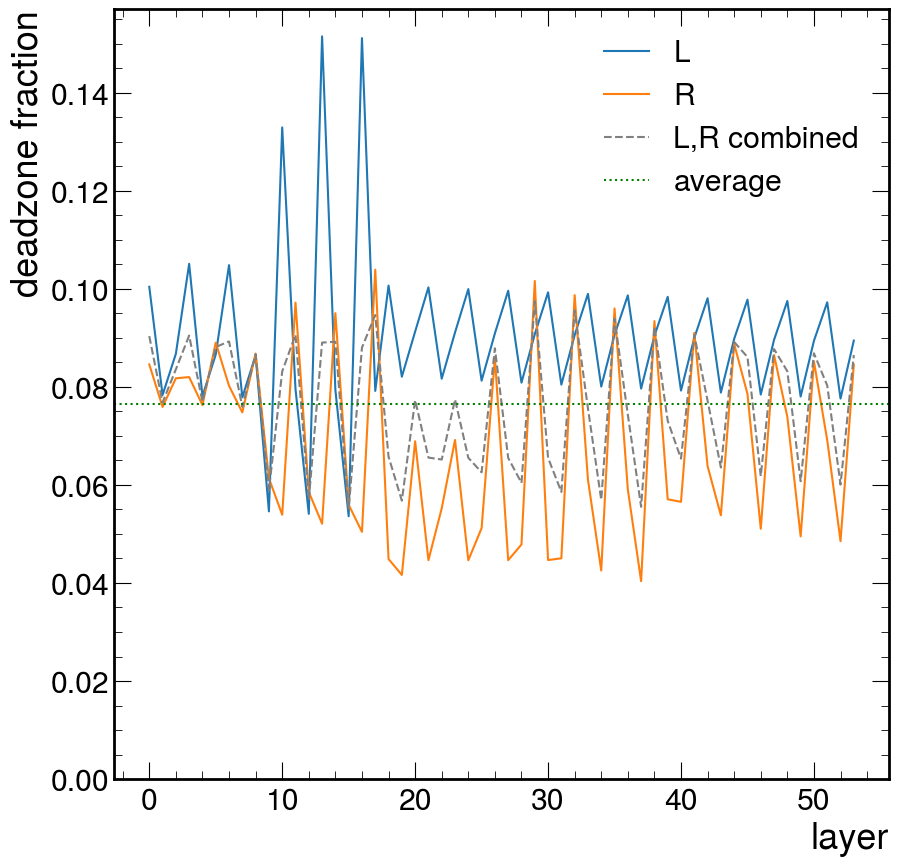

In [22]:
tot_dz={}
for s in "LR":
    df =summary.query(f"side=='{s}'")
    plt.plot(df.layer, df.deadzone_frac, label=s)
    
dfL=summary.query(f"side=='L'")
dfR=summary.query(f"side=='R'")

plt.plot(np.array(dfR.layer), (np.array(dfL.deadzone_area)+np.array(dfR.deadzone_area))/
         (np.array(dfL.tot_area)+np.array(dfR.tot_area)), label="L,R combined", color='0.5', linestyle='--')

plt.axhline(np.sum(summary.deadzone_area)/np.sum(summary.tot_area), linestyle=':', color='g', label='average')

plt.legend()
plt.xlabel("layer")
plt.ylabel("deadzone fraction")
plt.ylim(0)

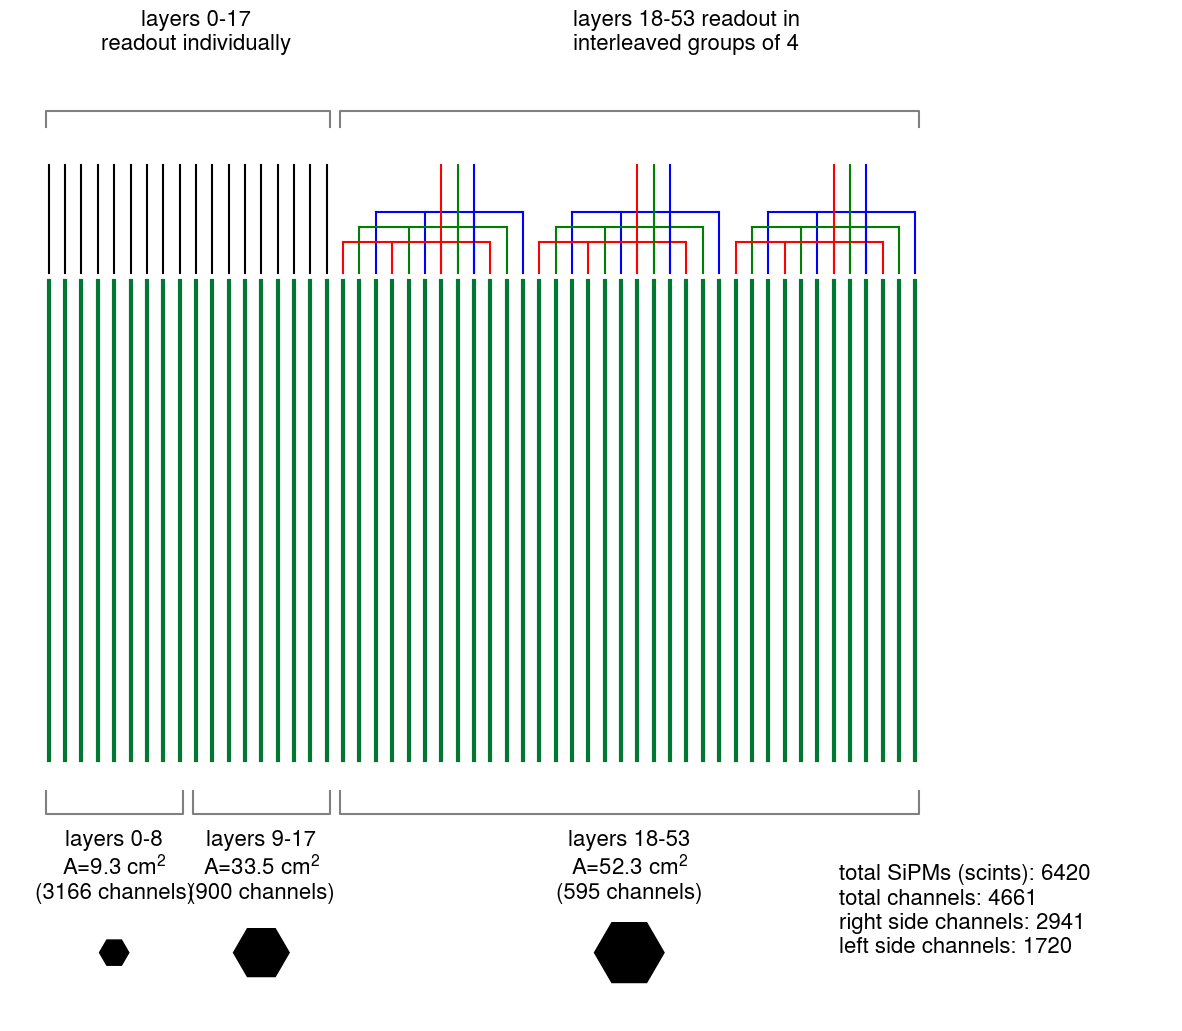

In [34]:
#draw the multi-layer structure:
fig, axs=plt.subplots(1,1, figsize=(15, 13))

coord_length=dp.coord_thickness
height=dp.det_height


txt_args=dict(fontsize=16)

for i in range(54):
    
    plt.plot([i*coord_length]*2, [-height/2, height/2], color='#007733', linewidth=3)

#now draw braces showing different sections by cell size
ranges=(0,8), (9, 17), (18, 53)
a=[dp.sidelengths[i] for i in (0, 9, 18)]
labels=[f"A={aa**2*3*np.sqrt(3)/2:.1f} cm$^2$" for aa in a]


for i in range(len(ranges)): 
    r=ranges[i]
    plt.plot([r[0]*coord_length-.4]*2+[r[1]*coord_length+.4]*2, 
             [-height/2-4, -height/2-7, -height/2-7, -height/2-4], color='0.5')
    plt.text((r[0]+r[1])/2*coord_length, -height/2-18,
             f"layers {r[0]}-{r[1]}\n{labels[i]}\n({nchan[i]} channels)", ha='center',**txt_args)

plt.text(102, -height/2-25, 
         f"total SiPMs (scints):\t{tot_cells}\n" \
         +f"total channels:\t{tot_chan}\nright side channels:\t{tot_chan_right}\nleft side channels:\t{tot_chan-tot_chan_right}",**txt_args)

#show hexagon sizes
phi=np.linspace(-np.pi, np.pi, 7)
for ai, r in zip(a, ranges):
    x=(r[0]+r[1])/2*coord_length+ai*np.cos(phi)
    y=-height/2-25+ai*np.sin(phi)
    plt.gca().add_patch(mpl.patches.Polygon(list(zip(x,y)), color='k'))
    
#now show where the layers are ganged together:
#unganged layers
for i in range(0,18):
    plt.plot([i*coord_length]*2,[height/2+1,height/2+15], color='k')

#ganged layers

colors="rgb"
for i in range(18, 54):
    plt.plot([i*coord_length]*2, [height/2+1,height/2+5+2*((i-18)%3)], color=colors[(i-24)%3])
for i in range(3):
    for j in range(3):
        plt.plot([(18+j*12+i)*coord_length, (18+j*12+i+9)*coord_length], 
                 [height/2+5+2*(i%3)]*2, color=colors[i%3])
for i in range(18, 21):
    for j in range(3):
        plt.plot([(i+6+j*12)*coord_length]*2, [height/2+1, height/2+15], color=colors[i%3])

plt.text(9*coord_length, height/2+30, "layers 0-17\nreadout individually", ha='center',**txt_args)

plt.text(39*coord_length, height/2+30, "layers 18-53 readout in\ninterleaved groups of 4", ha='center',**txt_args)
#braces for different types of readout
plt.plot([-.4]*2+[.4+coord_length*17]*2, [height/2+20, height/2+22, height/2+22, height/2+20],
        color='0.5')
plt.plot([-.4+coord_length*18]*2+[.4+coord_length*53]*2, [height/2+20, height/2+22, height/2+22, height/2+20],
        color='0.5')

        
plt.xlim(-5, 145)
plt.ylim(-65, 65)
plt.gca().axis('off')
plt.show()


In [24]:
for layer, side in all_layers:
    with open(f"openscad/boundaries_{layer}_{side}.scad", "w") as f:
        write_for_openscad(all_layers[(layer,side)], file=f)

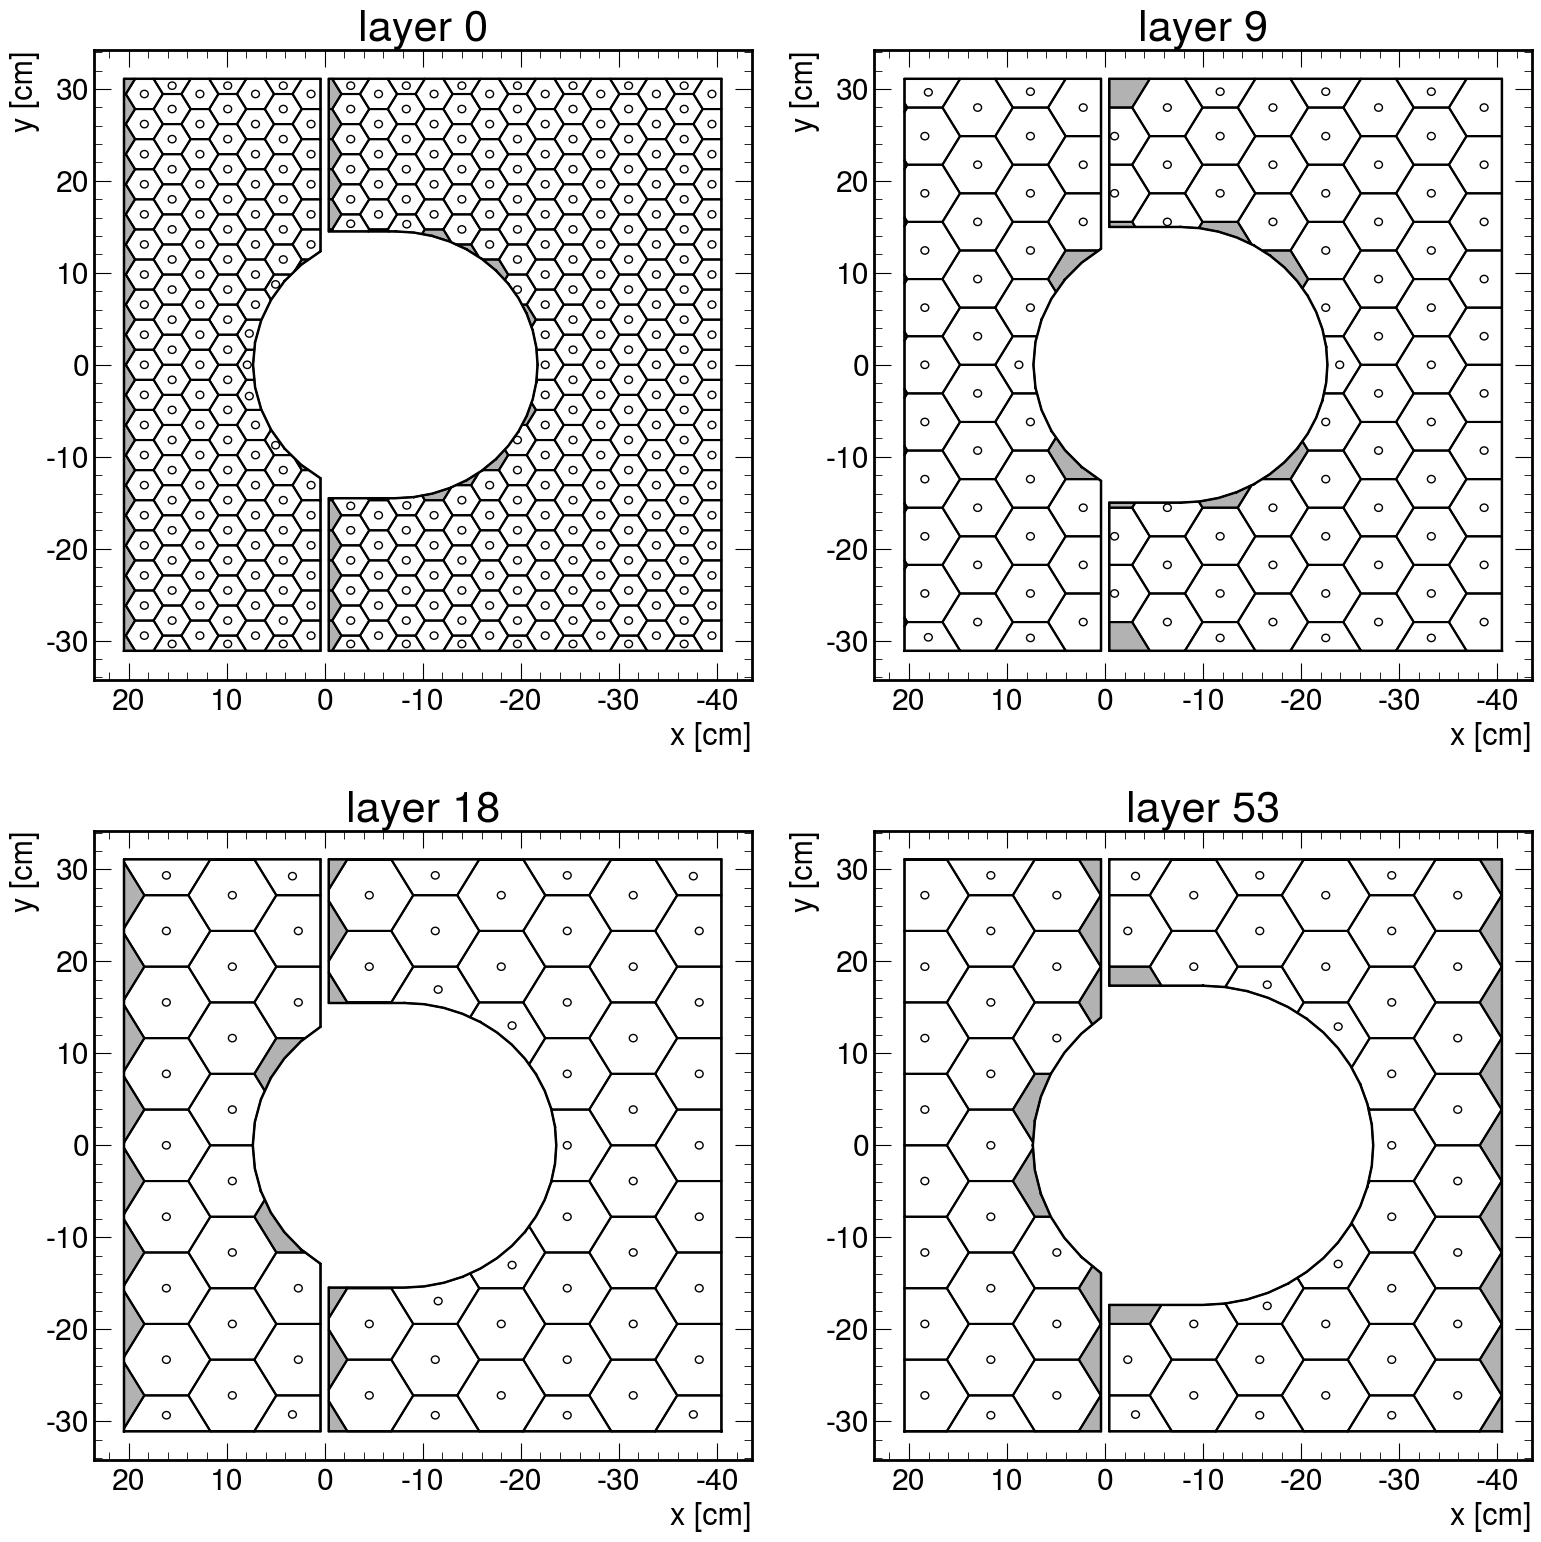

In [25]:



arg=dict(fillDimple=False, color='k')
fig,axs=plt.subplots(2,2, figsize=(16,16))
for i,layer in enumerate((0, 9, 18, 53)):

    plt.sca(axs[i//2][i%2])
    plt.title(f"layer {layer}")
    draw_layer(layer, **arg, sidelength=sidelengths[layer])
    plt.gca().invert_xaxis()
for row in axs:
    for ax in row:
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        
plt.tight_layout()
plt.savefig(f"representative_layers.pdf")
plt.show()

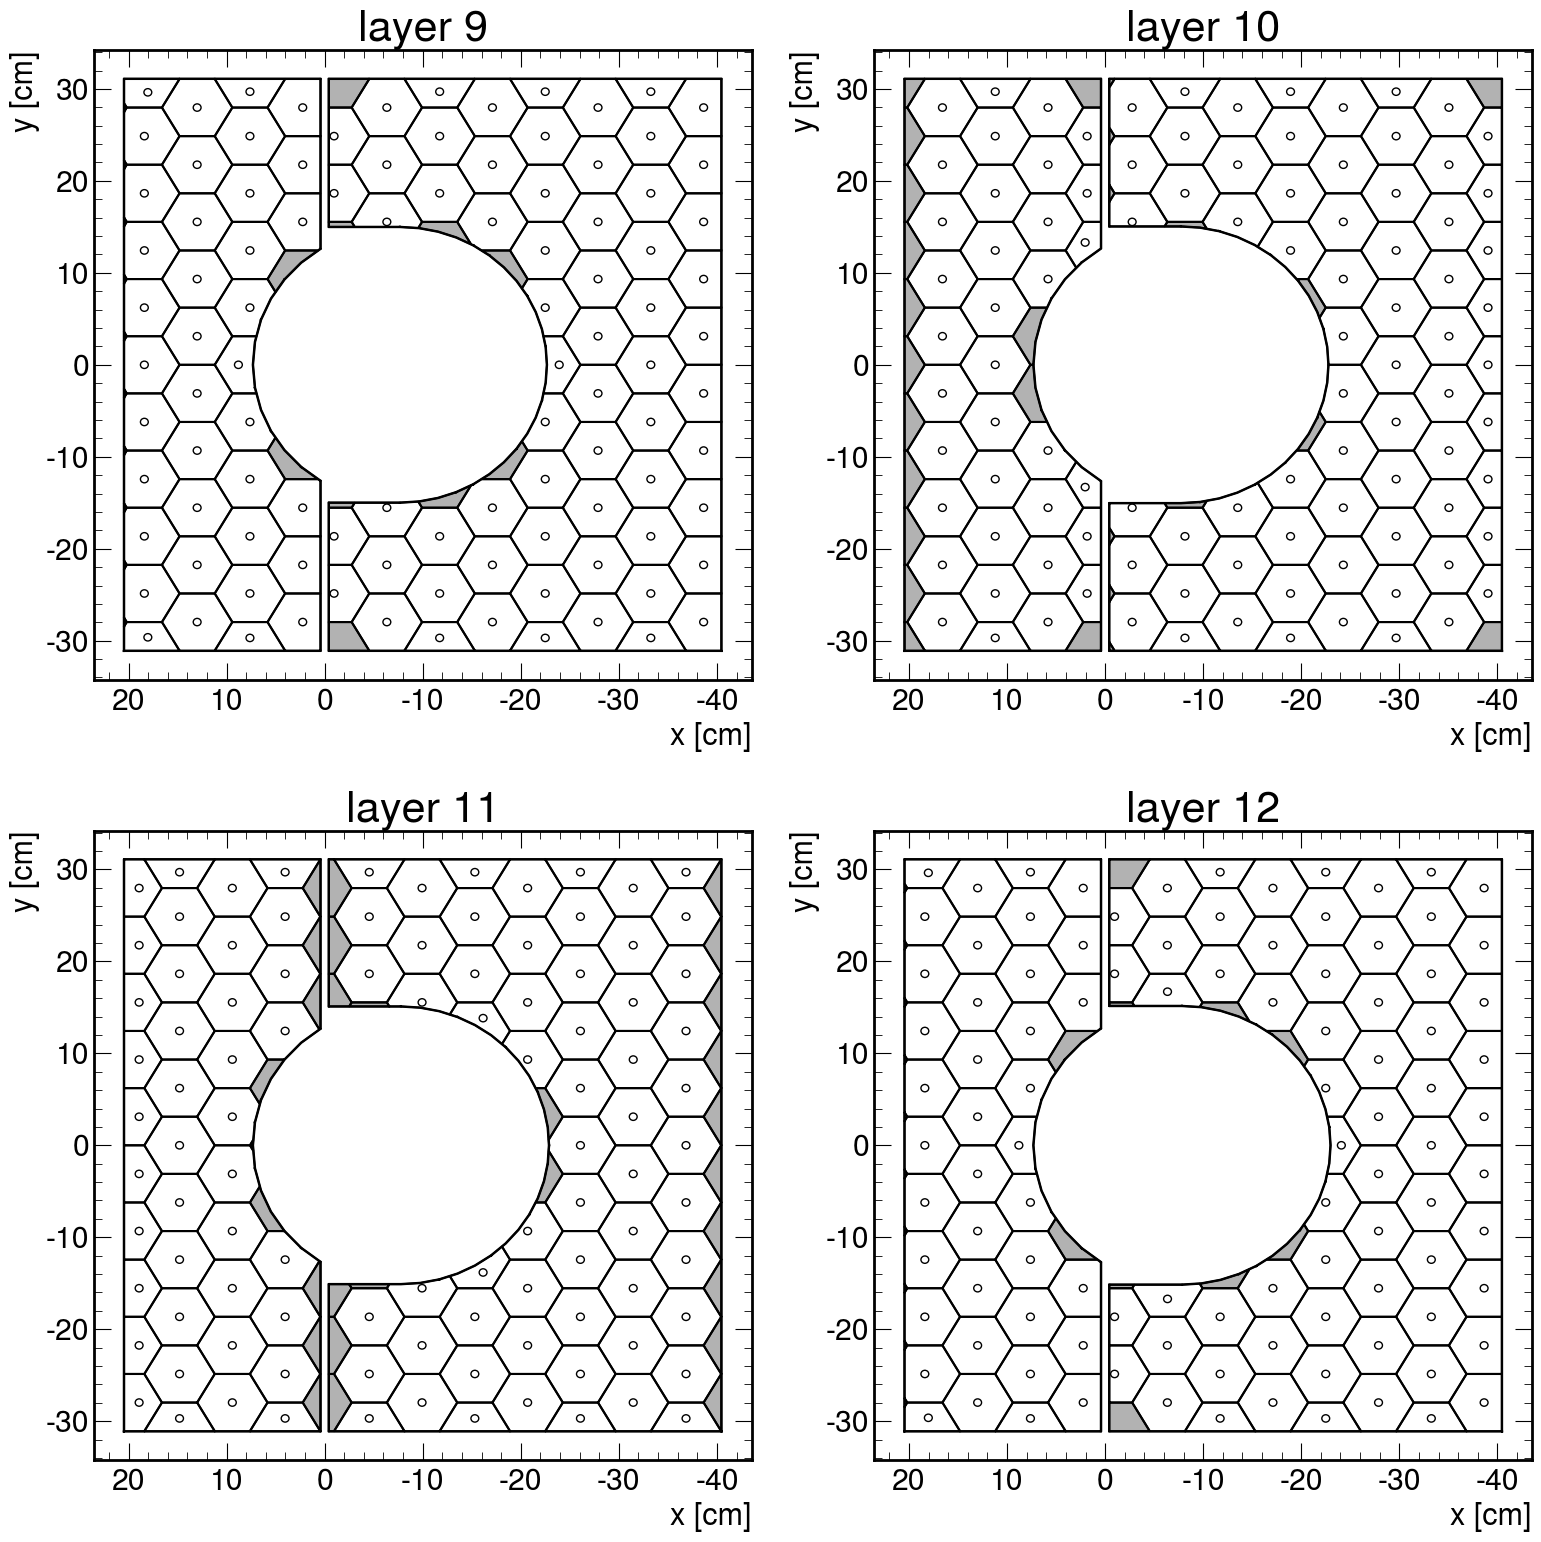

In [26]:
sidelengths[9]*np.sqrt(3)/2


arg=dict(fillDimple=False, color='k')
fig,axs=plt.subplots(2,2, figsize=(16,16))
for i,layer in enumerate((9, 10, 11,12)):

    plt.sca(axs[i//2][i%2])
    plt.title(f"layer {layer}")
    draw_layer(layer, **arg, sidelength=sidelengths[layer])
    plt.gca().invert_xaxis()
for row in axs:
    for ax in row:
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        
plt.tight_layout()
#plt.savefig(f"representative_layers.pdf")
plt.show()

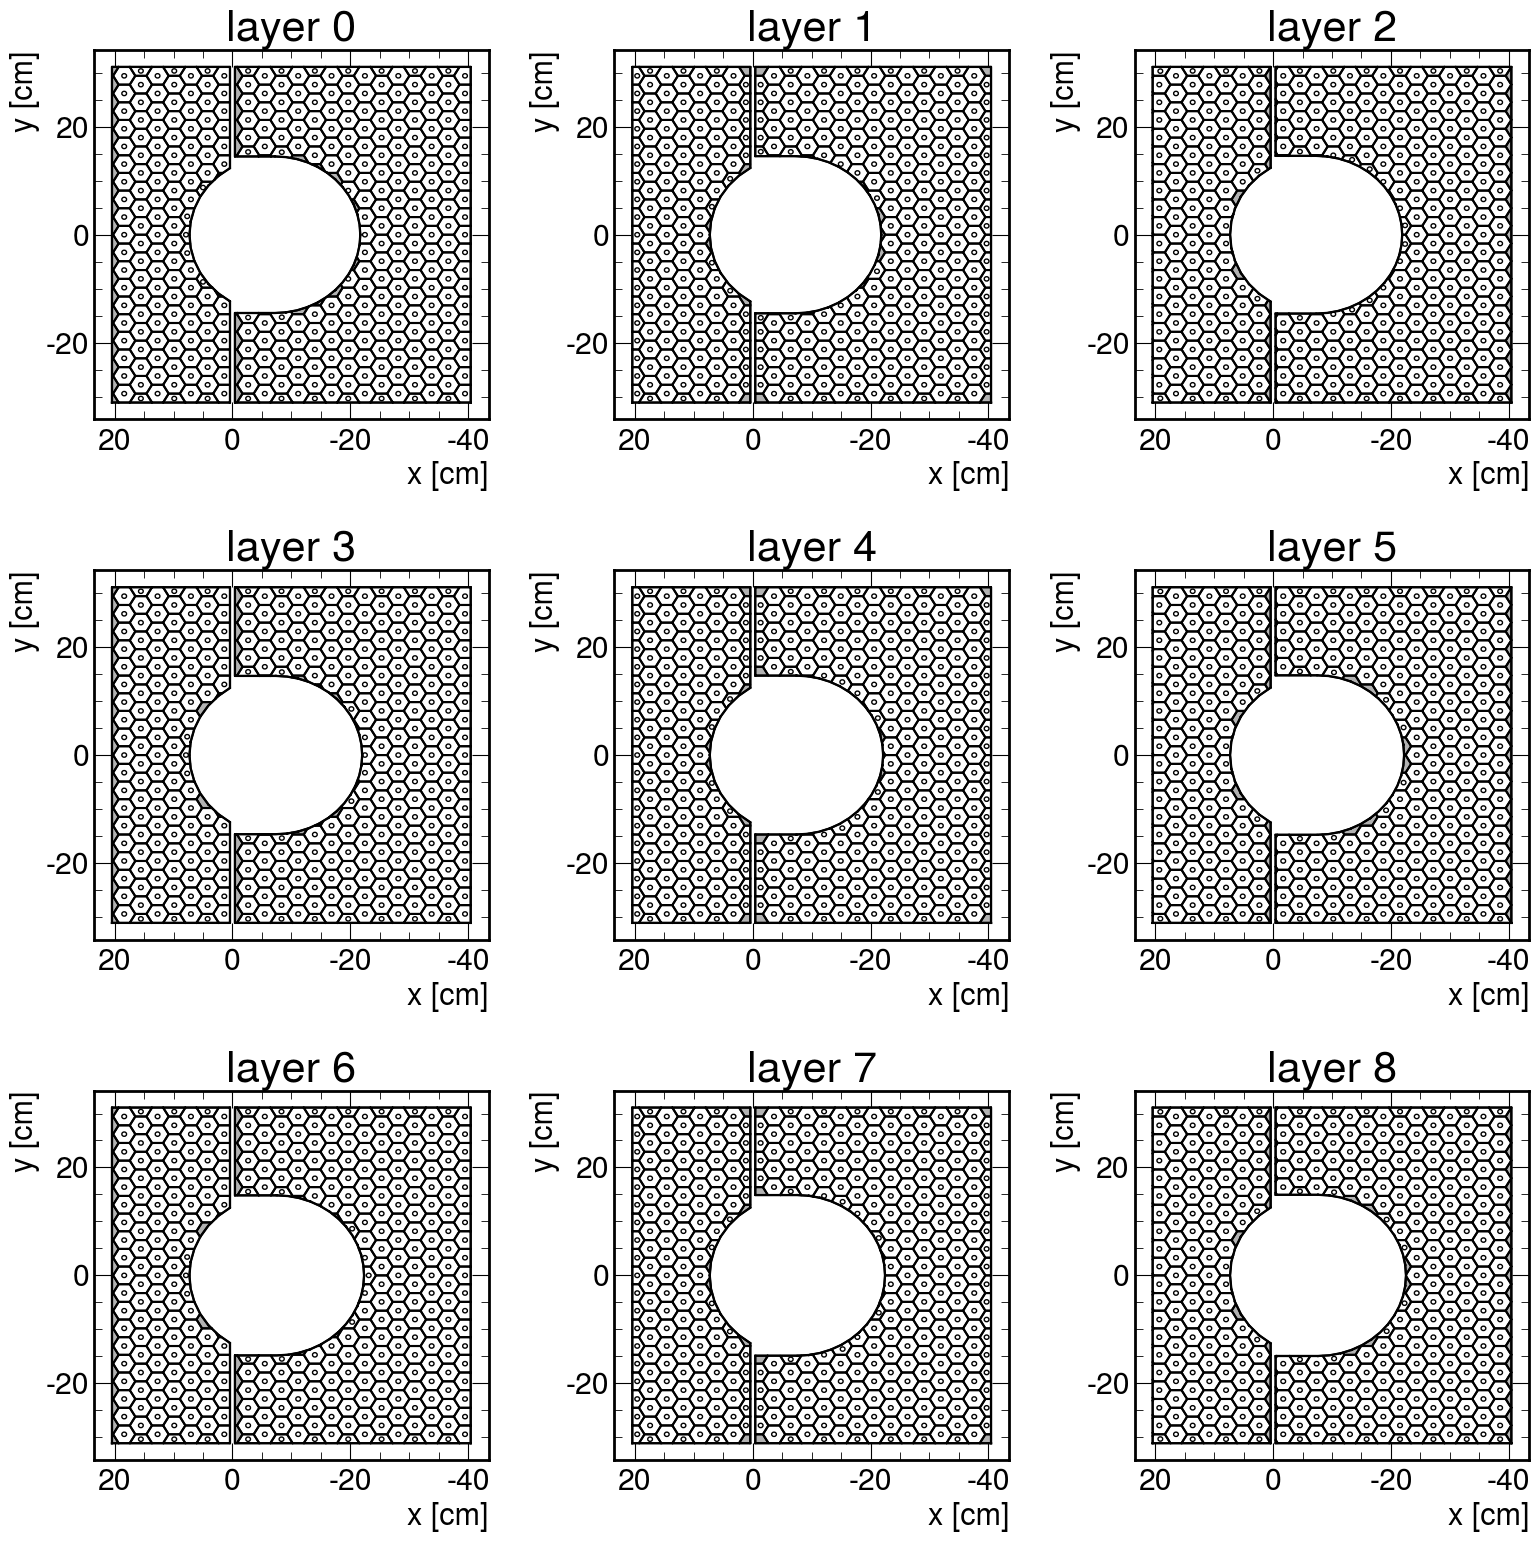

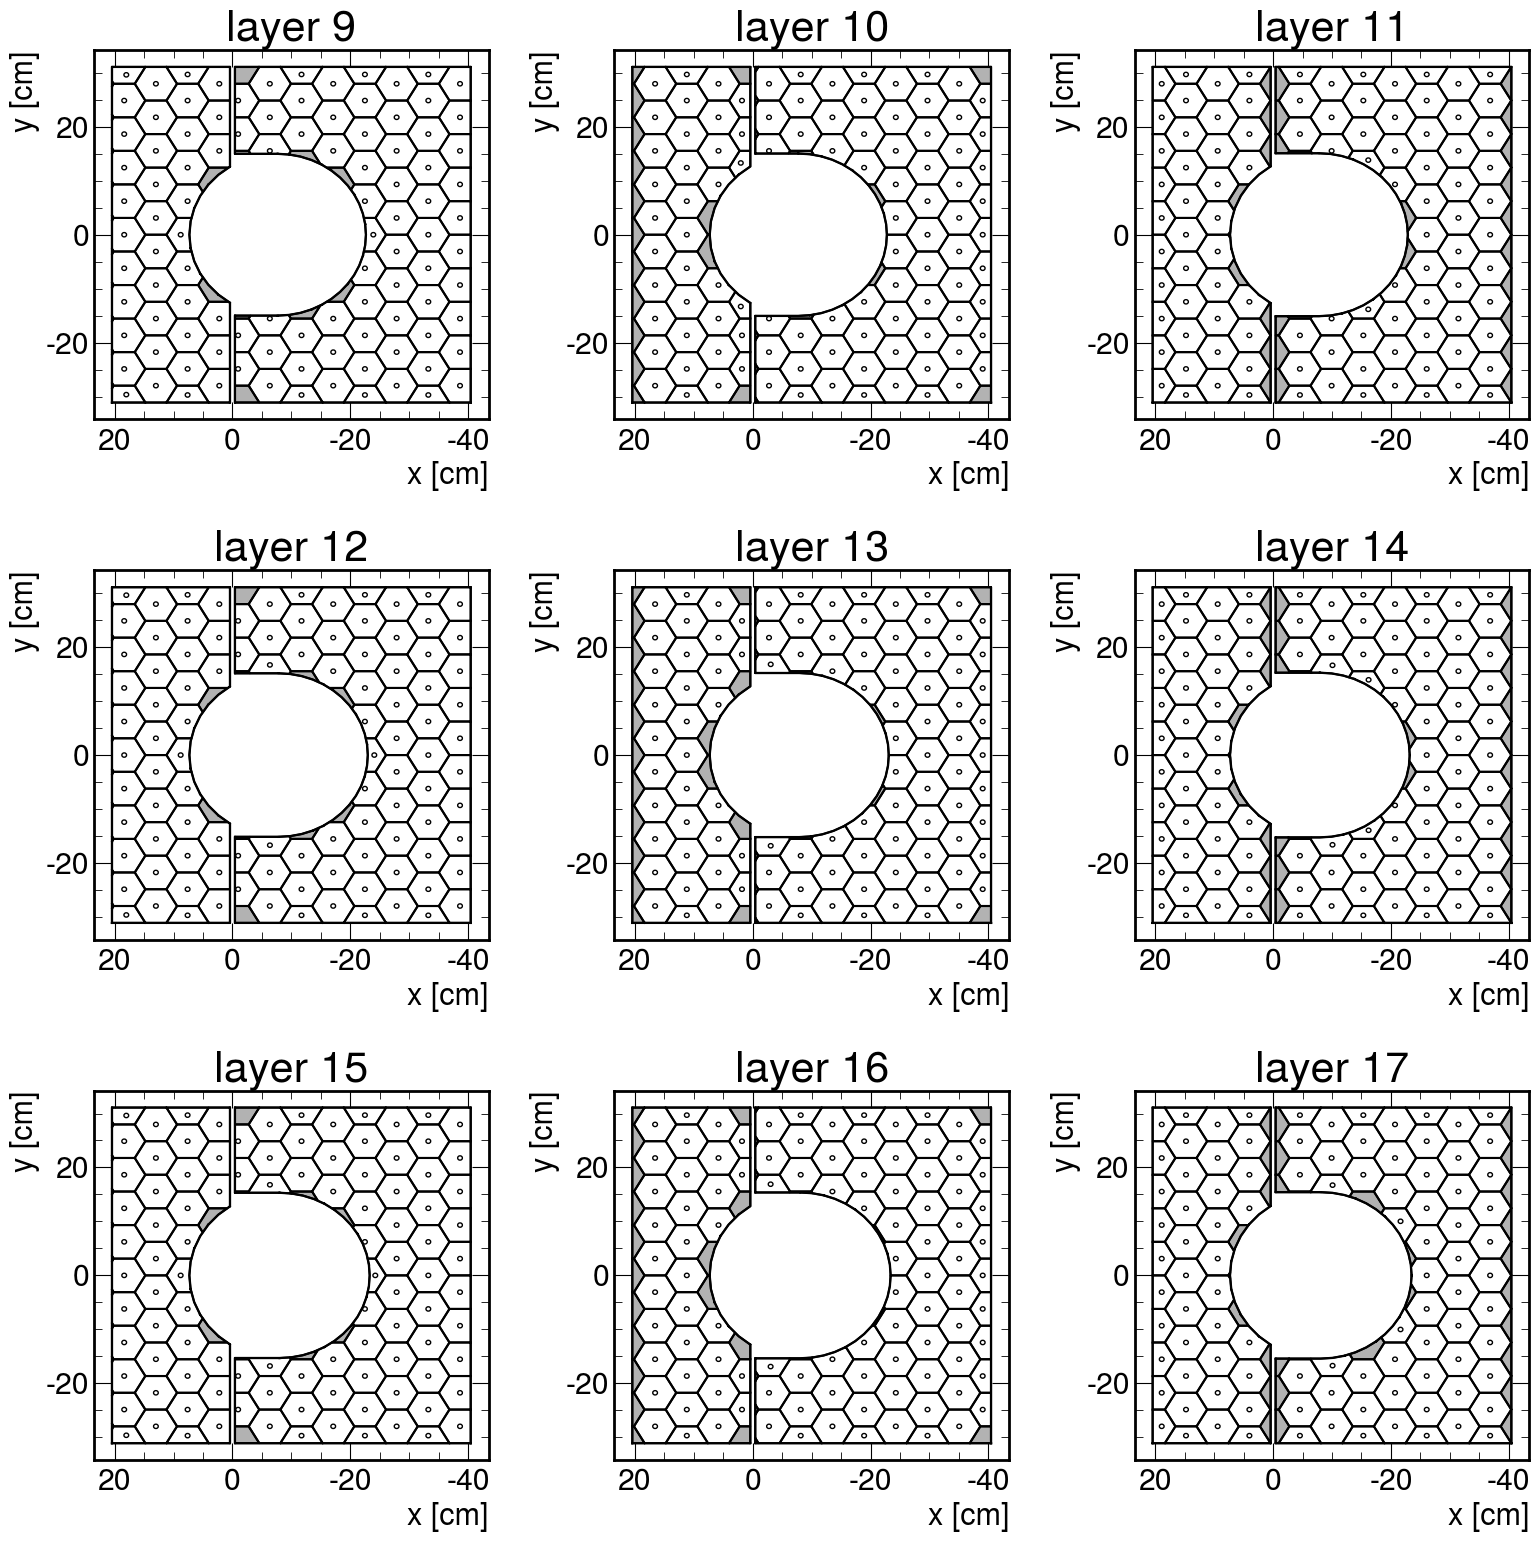

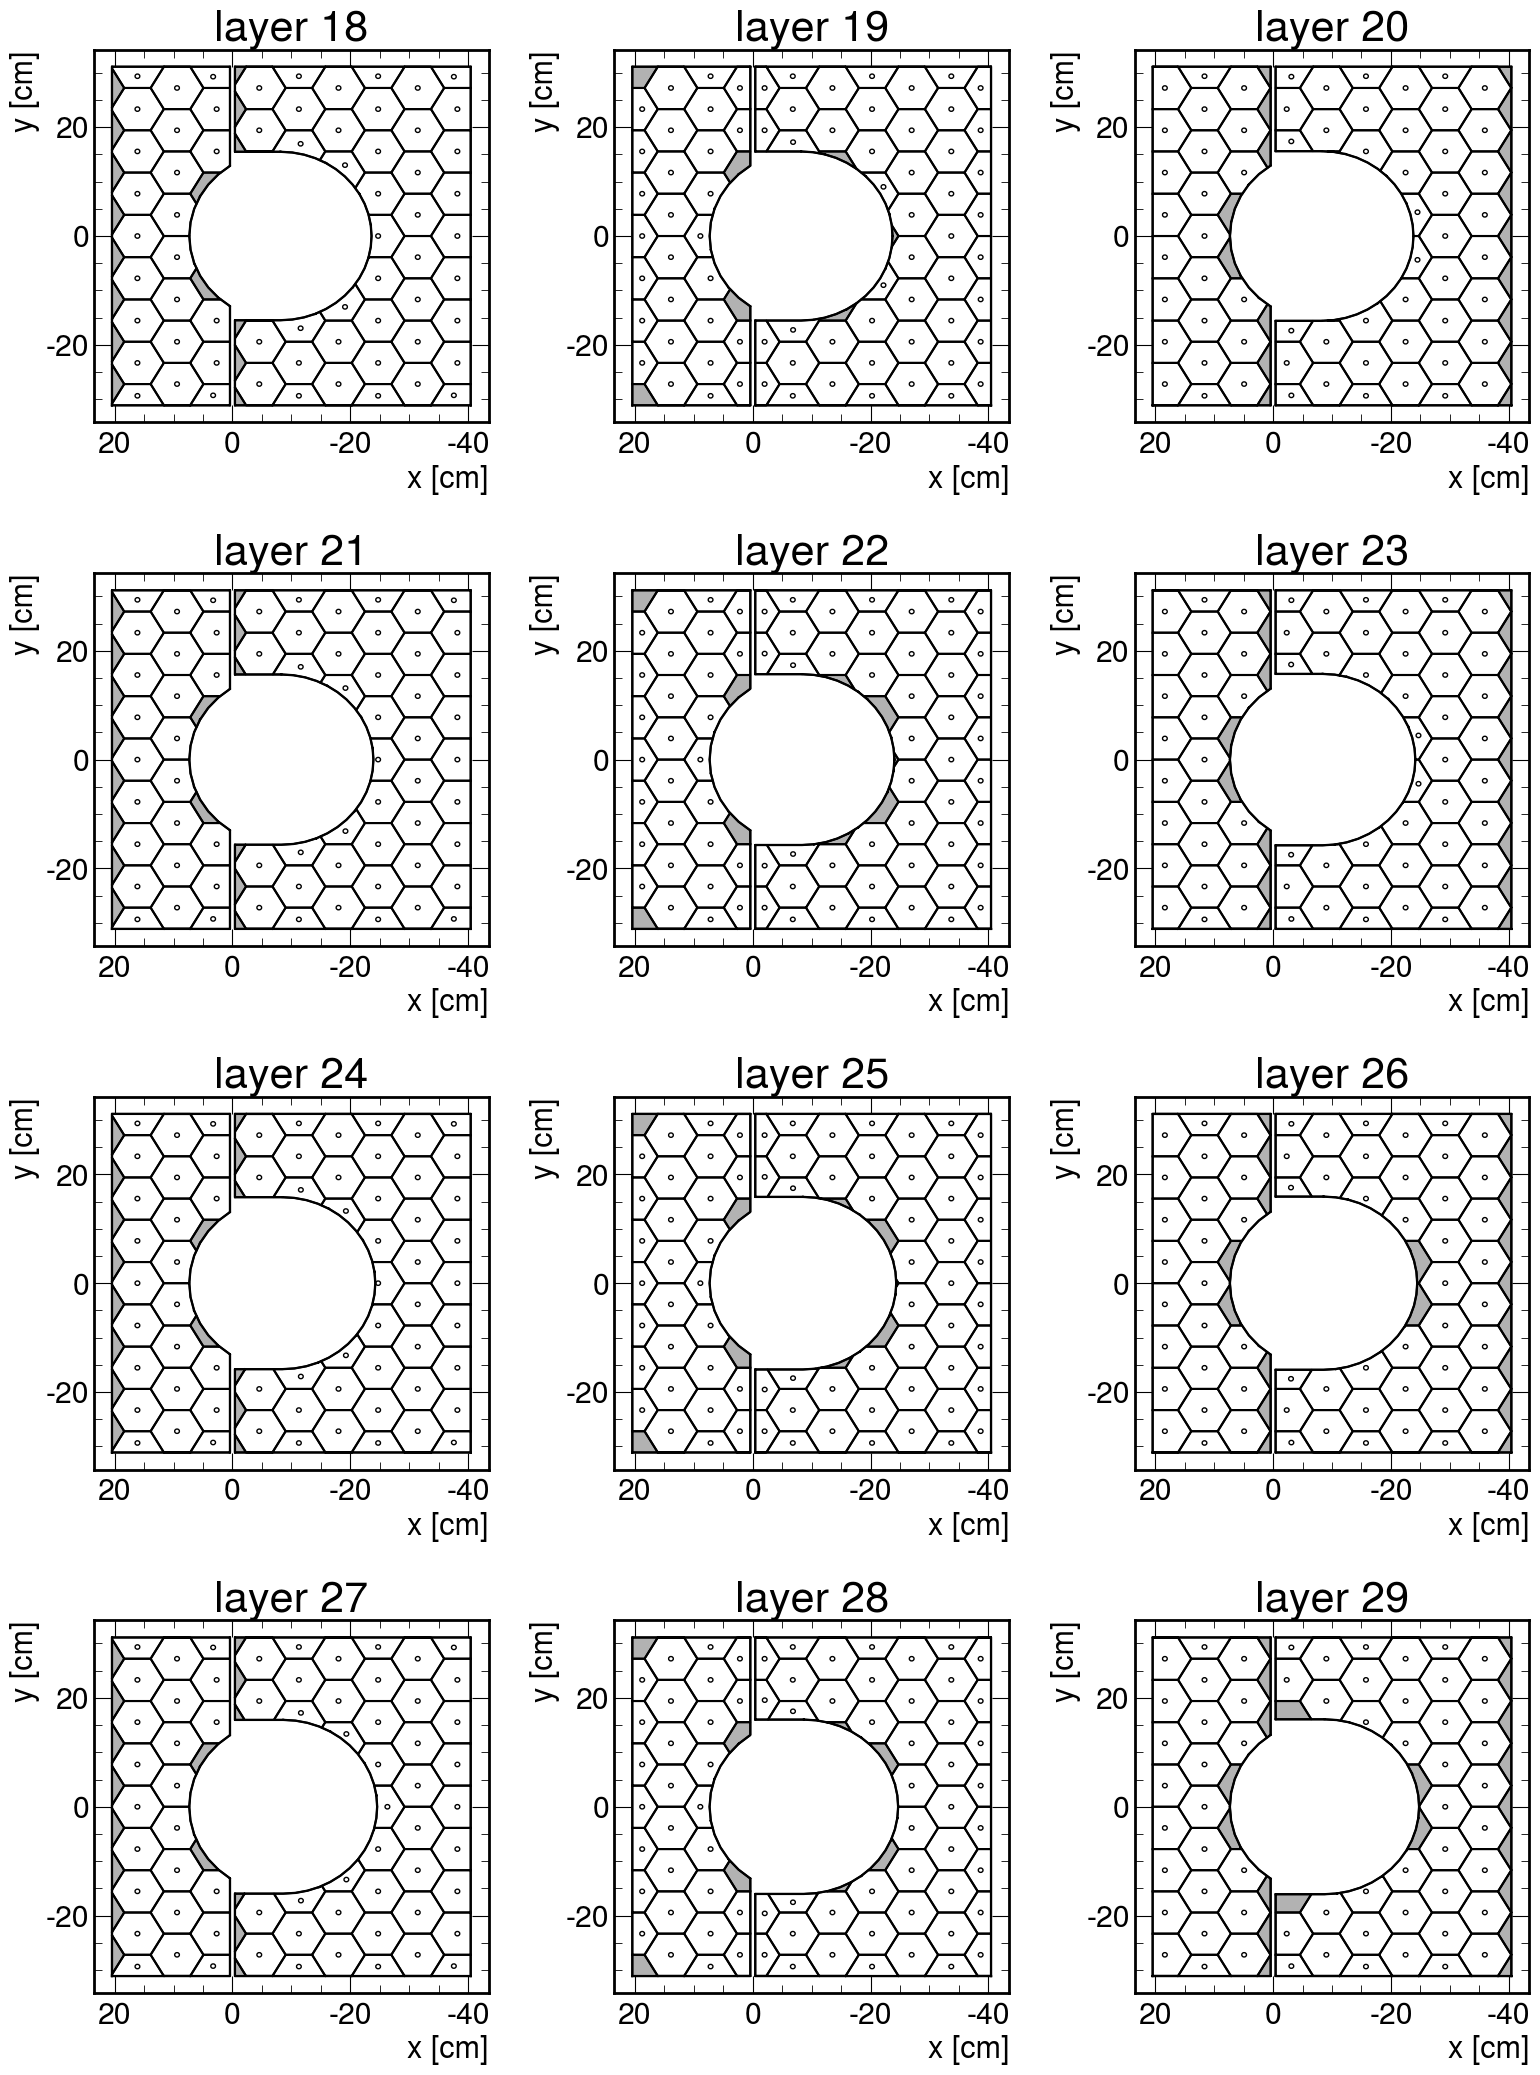

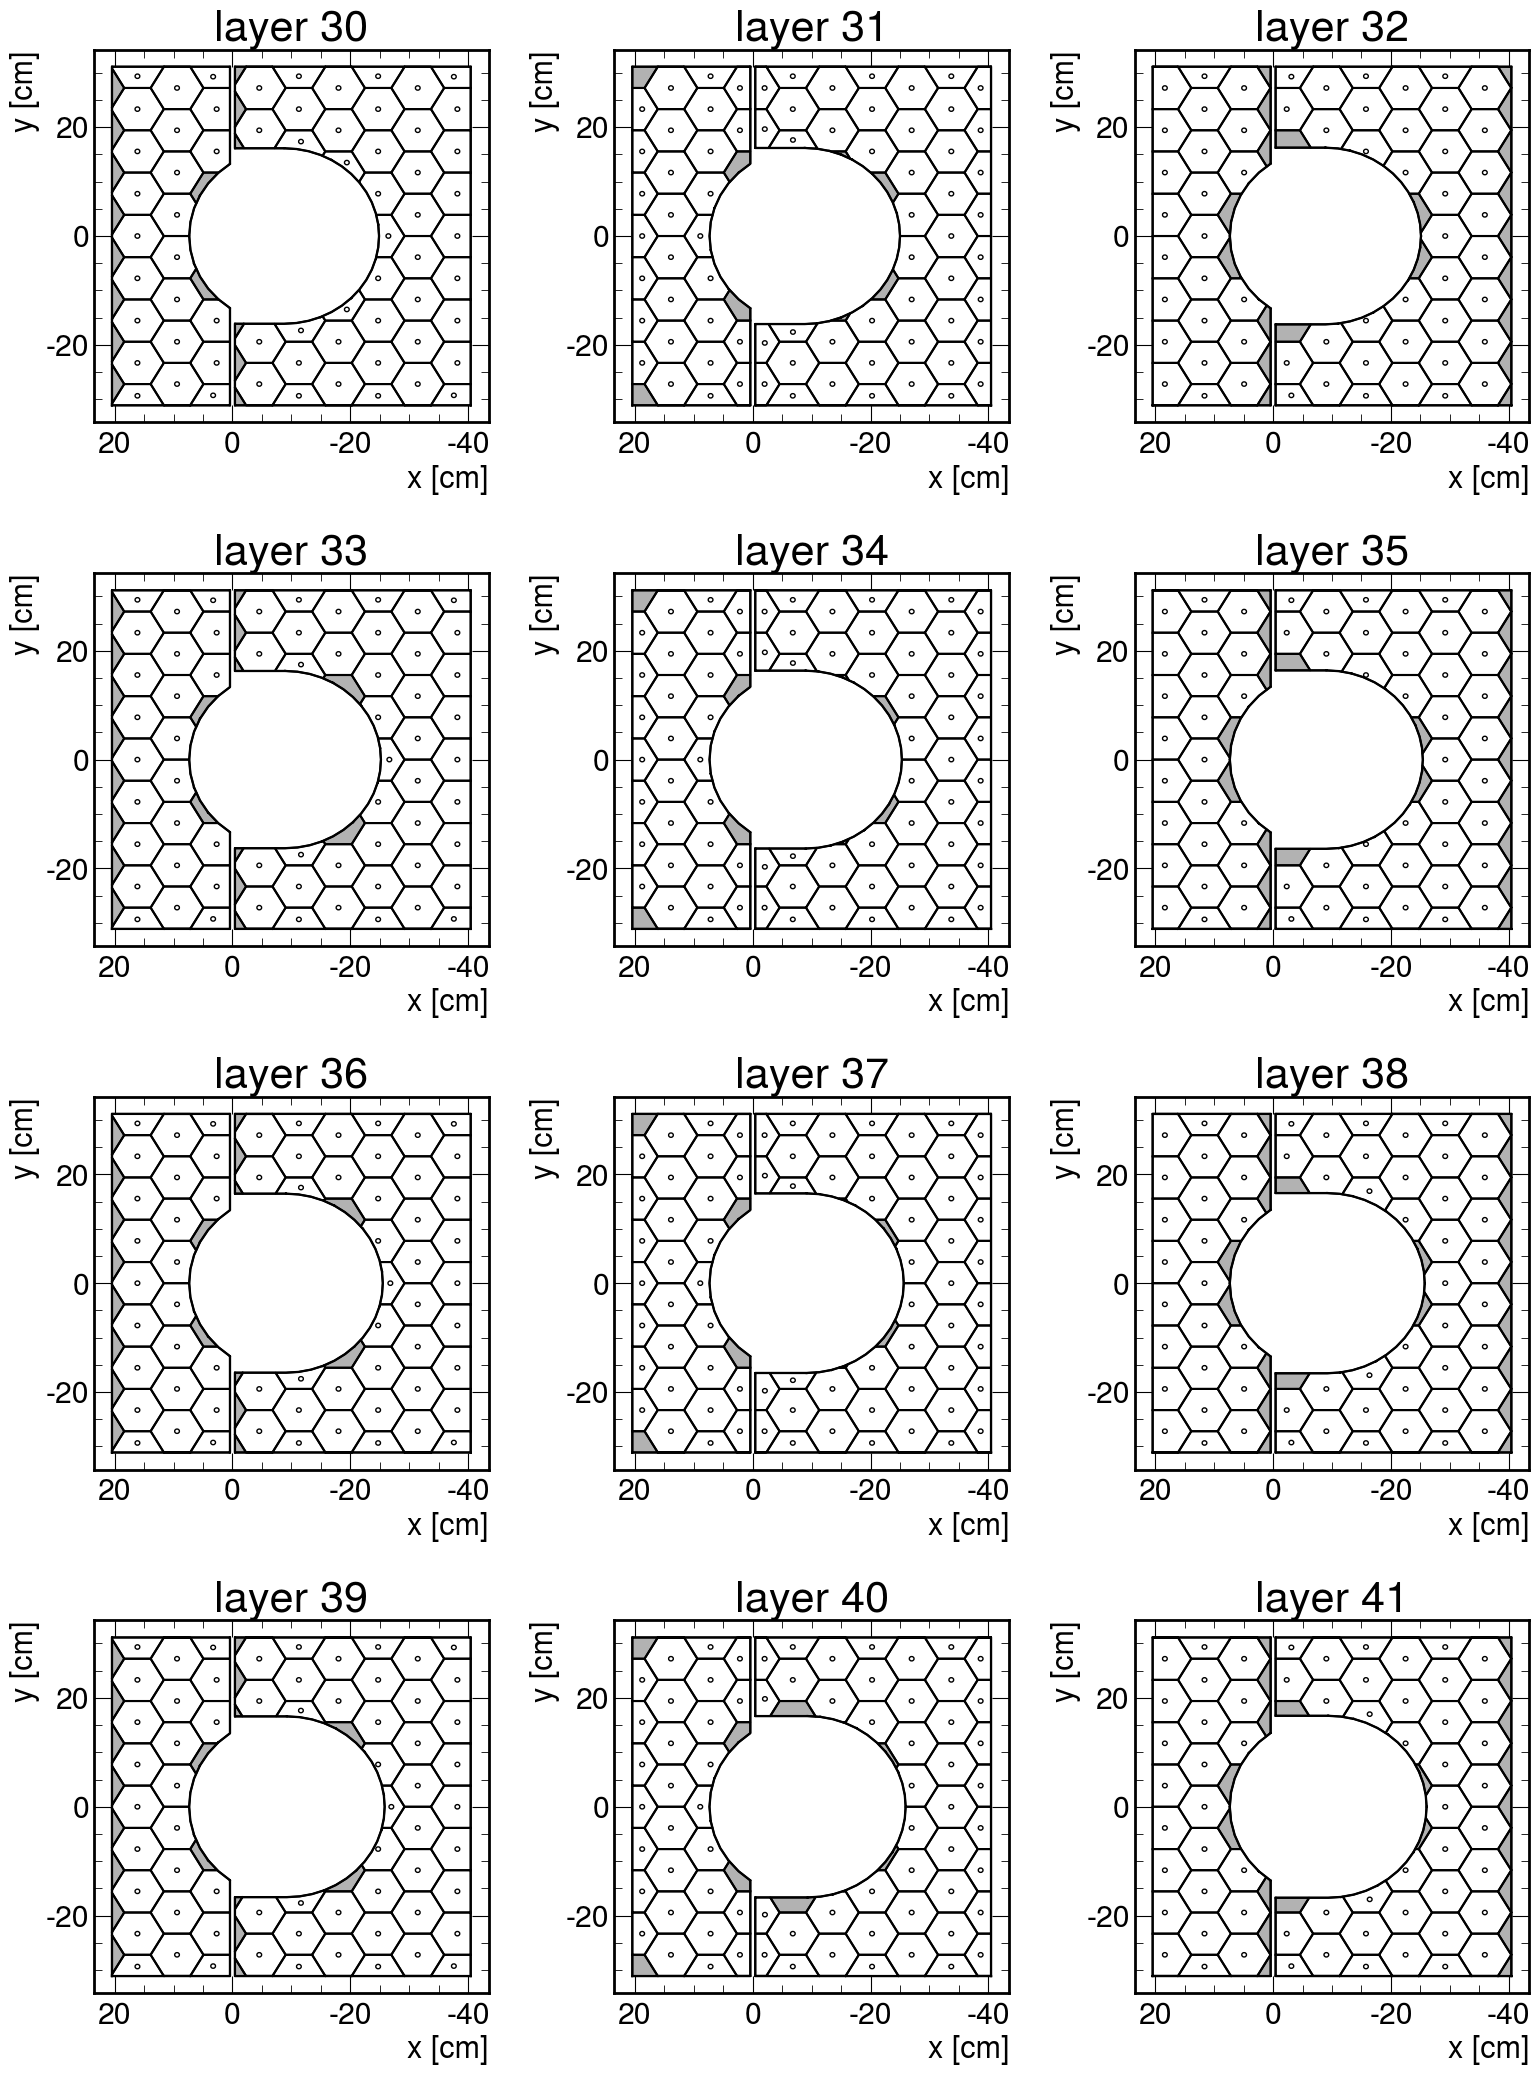

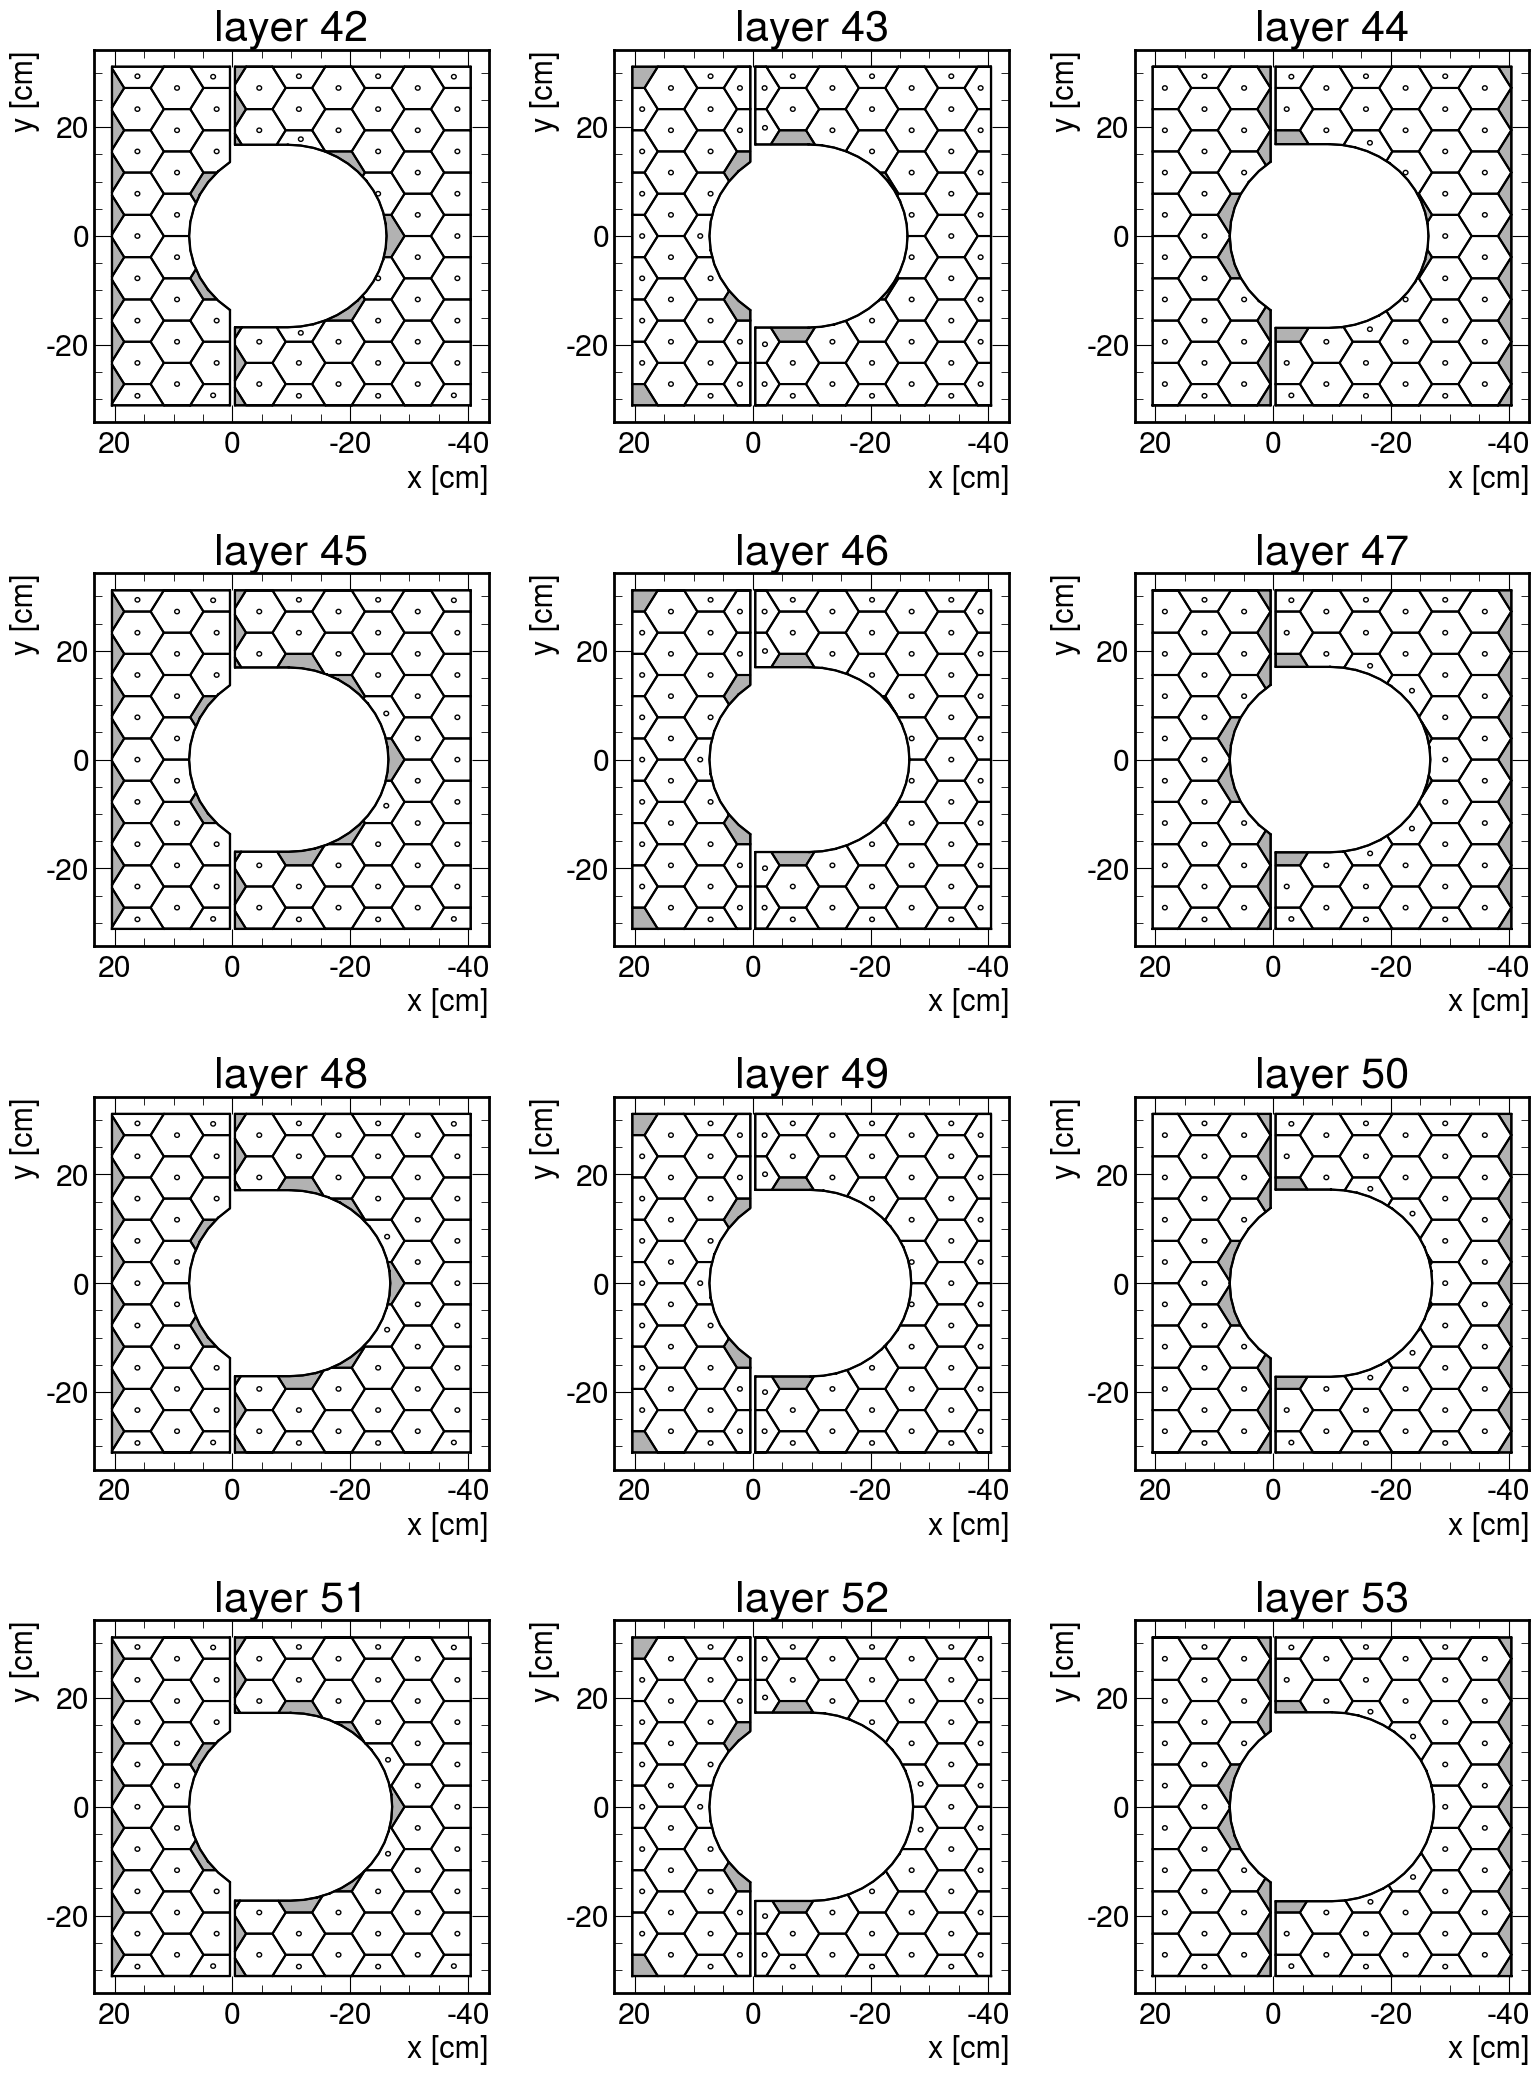

In [27]:
#now make a multi-page pdf with all of the layers
# Instantiating PDF document
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('all_layers_layout.pdf')

for j in range(5):

    arg=dict(fillDimple=False, color='k')
    nrows = 3 if j < 2 else 4
    fig,axs=plt.subplots(nrows,3, figsize=(16,16*nrows/3))
    for i in range(3*nrows):
        layer = j*9+i if j<2 else 18+(j-2)*12+i 
        plt.sca(axs[i//3][i%3])
        plt.title(f"layer {layer}")
        draw_layer(layer, **arg, sidelength=sidelengths[layer])
        plt.gca().invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)

    plt.tight_layout()
    # Saving figures on pdf pages
    pdf.savefig(fig)
    #plt.savefig(f"representative_layers.pdf")
plt.show()

In [28]:
#create a pickle file with the layouts of all of the layers
import pickle
with open("all_layers.pkl",'wb') as f:
    pickle.dump(all_layers,f)
with open("summary.pkl", 'wb') as f:
    pickle.dump(summary,f)
    